In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-10-28 16:28:20 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-10-28 16:28:20 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-10-28 16:28:20 __main__ INFO     transformers.__version__='4.55.3'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
# model_key = "meta-llama/Llama-3.1-70B-Instruct"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-10-28 16:28:24 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-10-28 16:28:24 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-10-28 16:28:24 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-10-28 16:28:24 wandb.docker.auth DEBUG    No config file found


2025-10-28 16:28:25 matplotlib DEBUG    matplotlib data path: /disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data
2025-10-28 16:28:25 matplotlib DEBUG    CONFIGDIR=/disk/u/arnab/.config/matplotlib
2025-10-28 16:28:25 matplotlib DEBUG    interactive is False
2025-10-28 16:28:25 matplotlib DEBUG    platform is linux
2025-10-28 16:28:25 matplotlib DEBUG    CACHEDIR=/disk/u/arnab/.cache/matplotlib
2025-10-28 16:28:25 matplotlib.font_manager DEBUG    Using fontManager instance from /disk/u/arnab/.cache/matplotlib/fontlist-v390.json
2025-10-28 16:28:25 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-10-28 16:28:25 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-10-28 16:28:25 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-10-28 16:28:25 matplotlib.font

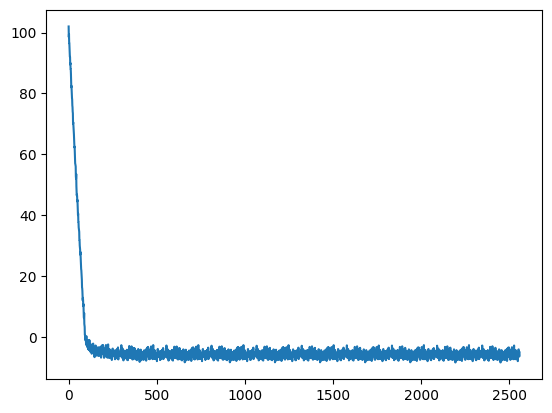

79


(True, True)

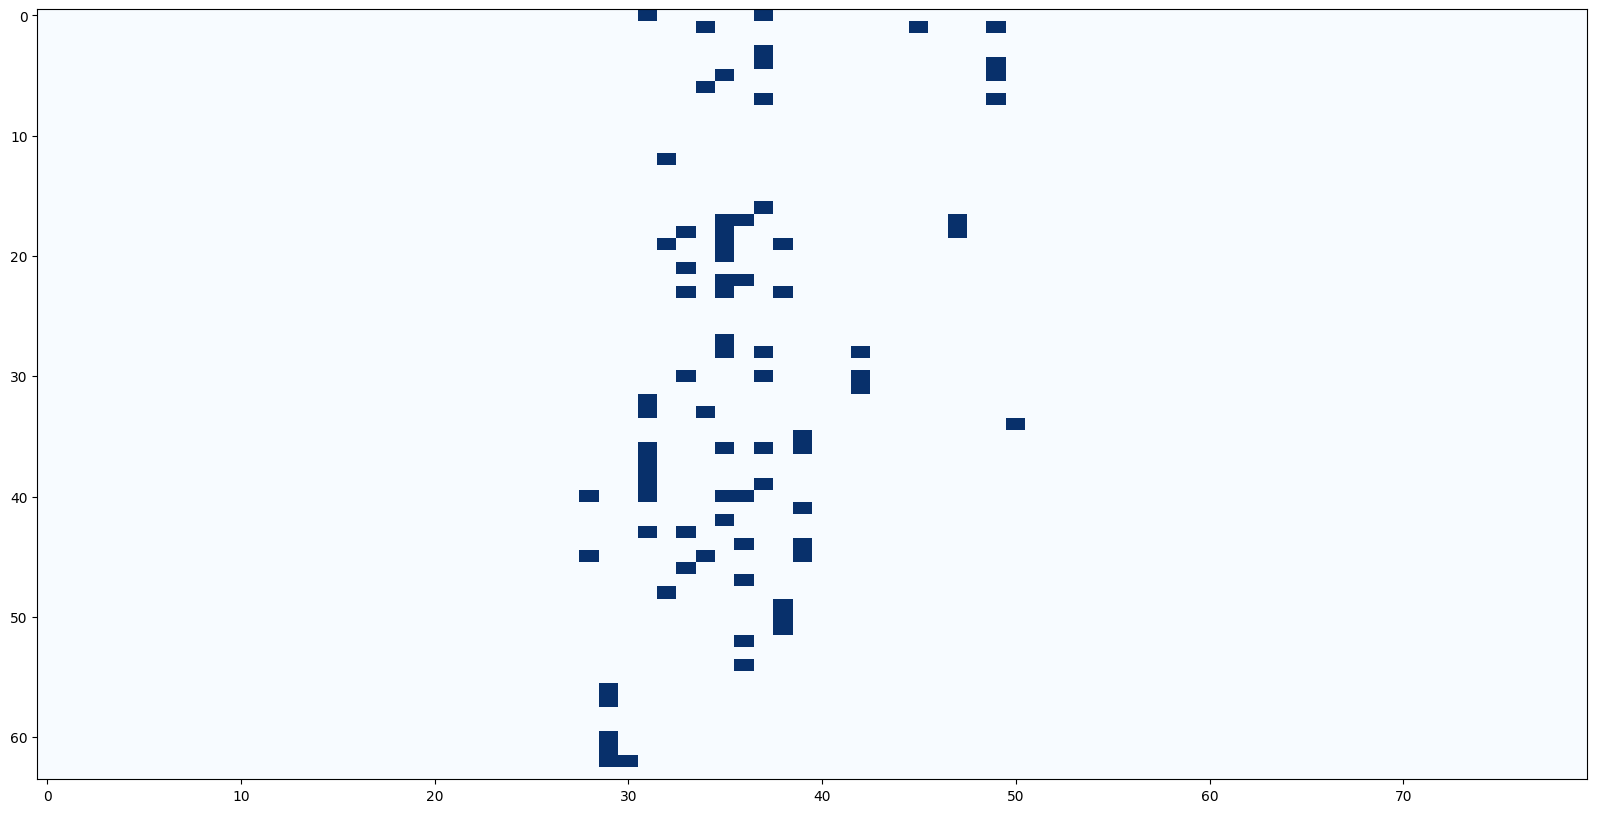

In [4]:
import sys

sys.path.append("../")

from matplotlib import pyplot as plt
import numpy as np
from src.utils import env_utils
import os
import torch

plt.rcdefaults()

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/optimized_heads",
    model_key.split("/")[-1],
    "distinct_options",
    # f"{select_task.task_name}",
    "select_one",
    # "legacy",
    "epoch_10.npz",
)

optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])
plt.show()

plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[52:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

optimized_heads = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
optimized_heads = [(layer_idx, head_idx) for layer_idx, head_idx in optimized_heads]
print(len(optimized_heads))

HEADS = optimized_heads

(35, 19) in HEADS, (35, 19) in optimized_heads
# [(29, 3) in HEADS]

## Load LM and the Select Task

In [5]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # torch_dtype=torch.float32,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-10-28 16:28:29 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-10-28 16:28:29 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-10-28 16:28:29 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-10-28 16:28:29 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-10-28 16:28:29 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/meta-llama/Llama-3.3-70B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-10-28 16:29:23 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-10-28 16:29:23 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-10-28 16:29:23 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [6]:
mt.model.layers[15].self_attn.config._attn_implementation

'eager'

In [7]:
import copy
import random
from src.selection.utils import KeyedSet, get_first_token_id, verify_correct_option
from src.selection.data import SelectionSample
from src.functional import predict_next_token
from src.tokens import prepare_input
from src.selection.data import get_counterfactual_samples_within_task

from src.selection.data import SelectOneTask

#################################################################################
# TASK_CLS = SelectOrderTask
# prompt_template_idx = 1
TASK_CLS = SelectOneTask
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR,
        "selection",
        # "profession.json"
        # "nationality.json"
        "objects.json",
    )
)

print(select_task)

source, destination = get_counterfactual_samples_within_task(
    # patch_category="politician",
    # clean_category="actor",
    mt=mt,
    task=select_task,
    patch_category="fruit",
    clean_category="vehicle",
    filter_by_lm_prediction=True,
    prompt_template_idx=prompt_template_idx,
    option_style=OPTION_STYLE,
    distinct_options=True,
    patch_n_distractors=5,
    clean_n_distractors=5,
)

# patch_sample.default_option_style = "single_line"
# clean_sample.default_option_style = "numbered"

print(source.prompt(), ">>", source.obj)
print(destination.prompt(), ">>", destination.obj)

['name', 'prompt_templates', 'odd_one_prompt_templates', 'order_prompt_templates', 'count_prompt_templates', 'yes_no_prompt_templates', 'first_item_in_cat_prompt_templates', 'last_item_in_cat_prompt_templates', 'categories', 'exclude_categories']
SelectOneTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(14), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)

2025-10-28 16:29:26 src.selection.data INFO     clean_obj_idx=1 | ['Violin', 'Submarine', 'Watermelon', 'Baseball', 'Projector', 'Charm']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-10-28 16:29:29 src.selection.data INFO     Options: Laptop, Warehouse, Skateboard, Car, Juicer, Kiwi.
Which among these objects mentioned above is a fruit?
Answer:
2025-10-28 16:29:29 src.selection.data INFO     Pineapple | fruit -> Kiwi | pred=['" Ki"[30558]

In [8]:
from src.functional import generate_with_patch
from src.selection.functional import verify_head_patterns

print(destination.prompt(), ">>", destination.obj)
print(source.prompt(), ">>", source.obj)

gold_sample = copy.deepcopy(source)
gold_sample.options = copy.deepcopy(destination.options)

layer_idx, head_idx = (35, 19)

for sample in [source, destination, gold_sample]:
    print(sample.prompt(), ">>", f'"{mt.tokenizer.decode([sample.ans_token_id])}"')
    attn_pattern = verify_head_patterns(
        prompt=sample.prompt(),
        options=sample.options,
        mt=mt,
        heads=[(35, 19)],
        query_index=-1,
    )

Options: Violin, Submarine, Watermelon, Baseball, Projector, Charm.
Which among these objects mentioned above is a vehicle?
Answer: >> Submarine
Options: Laptop, Warehouse, Skateboard, Car, Juicer, Kiwi.
Which among these objects mentioned above is a fruit?
Answer: >> Kiwi
Options: Laptop, Warehouse, Skateboard, Car, Juicer, Kiwi.
Which among these objects mentioned above is a fruit?
Answer: >> " Ki"
2025-10-28 16:29:32 src.selection.functional DEBUG    Predictions: ['" Ki"[30558] (p=0.895, logit=23.250)', '" The"[578] (p=0.051, logit=20.375)', '" Among"[22395] (p=0.021, logit=19.500)', '" A"[362] (p=0.016, logit=19.250)', '" ki"[20548] (p=0.002, logit=17.125)']
2025-10-28 16:29:32 src.selection.functional INFO     Combined attention matrix for all heads


Options: Violin, Submarine, Watermelon, Baseball, Projector, Charm.
Which among these objects mentioned above is a vehicle?
Answer: >> " Sub"
2025-10-28 16:29:38 src.selection.functional DEBUG    Predictions: ['" Sub"[3804] (p=0.727, logit=21.625)', '" A"[362] (p=0.098, logit=19.625)', '" The"[578] (p=0.077, logit=19.375)', '" Among"[22395] (p=0.060, logit=19.125)', '" It"[1102] (p=0.006, logit=16.875)']
2025-10-28 16:29:38 src.selection.functional INFO     Combined attention matrix for all heads


Options: Violin, Submarine, Watermelon, Baseball, Projector, Charm.
Which among these objects mentioned above is a fruit?
Answer: >> " Ki"
2025-10-28 16:29:38 src.selection.functional DEBUG    Predictions: ['" Water"[10164] (p=0.832, logit=22.375)', '" The"[578] (p=0.077, logit=20.000)', '" Among"[22395] (p=0.053, logit=19.625)', '" A"[362] (p=0.012, logit=18.125)', '" water"[3090] (p=0.004, logit=17.125)']
2025-10-28 16:29:38 src.selection.functional INFO     Combined attention matrix for all heads


## Debug QK-SVD Patching Logic

### Recalculating Attention Score

In [9]:
from src.tokens import prepare_input, find_token_range

sample = source
tokenized = prepare_input(
    prompts=sample.prompt(), tokenizer=mt, return_offsets_mapping=True
)
seq_len = tokenized.input_ids.shape[1]
offsets = tokenized.pop("offset_mapping")[0]

rand_obj = random.choice(list(set(sample.options) - {sample.obj}))
print(f"Random object: {rand_obj} | Answer: {sample.obj}")

answer_obj_idx = (
    find_token_range(
        string=sample.prompt(),
        substring=sample.obj,
        tokenizer=mt.tokenizer,
        offset_mapping=offsets,
    )[1]
    - 1
)

rand_obj_idx = (
    find_token_range(
        string=sample.prompt(),
        substring=rand_obj,
        tokenizer=mt.tokenizer,
        offset_mapping=offsets,
    )[1]
    - 1
)

print(
    f'Answer token idx: {answer_obj_idx}["{mt.tokenizer.decode(tokenized.input_ids[0][answer_obj_idx])}"], Random object token idx: {rand_obj_idx}["{mt.tokenizer.decode(tokenized.input_ids[0][rand_obj_idx])}"]'
)

Random object: Pressure cooker | Answer: Pineapple
Answer token idx: 15["apple"], Random object token idx: 18[" cooker"]


In [10]:
import baukit
import types
from src.functional import get_module_nnsight
from src.hooking.llama_attention import repeat_kv

###################################################################################
batch_size = 1  # tokenized.input_ids.shape[0]
n_heads = mt.config.num_attention_heads
head_dim = get_module_nnsight(mt._model, mt.attn_module_name_format.format(0)).head_dim
n_kv_groups = get_module_nnsight(
    mt._model, mt.attn_module_name_format.format(0)
).num_key_value_groups
query_idx = -1  # almost always the last token
###################################################################################

input_ln = mt.layer_name_format.format(layer_idx) + ".input_layernorm"

attn_block_name = mt.attn_module_name_format.format(layer_idx)
attn_block = baukit.get_module(mt._model, attn_block_name)

with mt.trace(tokenized) as trace:
    ln_module = get_module_nnsight(mt, input_ln)
    patch_ln = ln_module.output.save()

    q_proj_name = mt.attn_module_name_format.format(layer_idx) + ".q_proj"
    q_proj_module = get_module_nnsight(mt, q_proj_name)
    print(f"{q_proj_module.output.shape=}")
    q_proj = (
        q_proj_module.output.view(batch_size, seq_len, n_heads, head_dim)
        .transpose(1, 2)
        .save()
    )

    k_proj_name = mt.attn_module_name_format.format(layer_idx) + ".k_proj"
    k_proj_module = get_module_nnsight(mt, k_proj_name)
    print(f"{k_proj_module.output.shape=}")
    k_proj = (
        k_proj_module.output.view(batch_size, seq_len, -1, head_dim)
        .transpose(1, 2)
        .save()
    )
    # patch_q_proj = PatchSpec(
    #     location=(q_proj_name + f".{head_idx}", -1),
    #     patch=patch_q_proj[:, head_idx, query_idx, :].squeeze().save()
    # )

k_proj = repeat_kv(k_proj, n_kv_groups)
print(f"{q_proj.shape=}")
print(f"{k_proj.shape=}")

q_proj_module.output.shape=torch.Size([1, 32, 8192])
k_proj_module.output.shape=torch.Size([1, 32, 1024])
q_proj.shape=torch.Size([1, 64, 32, 128])
k_proj.shape=torch.Size([1, 64, 32, 128])


In [ ]:
####################################################################
query_idx = -1  # almost always the last token
key_idx = 12
####################################################################

head_q_out = q_proj[:, head_idx, query_idx, :]
head_k_out = k_proj[:, head_idx, key_idx, :]
source_query = patch_ln[:, query_idx, :]
key_inp = patch_ln[:, key_idx, :]

head_q_out.shape, head_k_out.shape, source_query.shape, key_inp.shape

(torch.Size([1, 128]),
 torch.Size([1, 128]),
 torch.Size([1, 8192]),
 torch.Size([1, 8192]))

In [ ]:
q_proj_2 = (
    attn_block.q_proj(source_query).view(batch_size, 1, n_heads, head_dim).transpose(1, 2)
)
head_q_out_2 = q_proj_2[:, head_idx, 0, :]
torch.allclose(head_q_out, head_q_out_2, atol=1e-2)

True

In [13]:
k_proj_2 = attn_block.k_proj(key_inp).view(batch_size, 1, -1, head_dim).transpose(1, 2)
head_k_out_2 = k_proj_2[:, head_idx // n_kv_groups, 0, :]
torch.allclose(head_k_out, head_k_out_2, atol=1e-1)

True

In [14]:
q_proj_per_head = attn_block.q_proj.weight.T.view(
    attn_block.q_proj.in_features, n_heads, head_dim
)
k_proj_per_head = attn_block.k_proj.weight.T.view(
    attn_block.k_proj.in_features, -1, head_dim
)
q_proj_per_head.shape, k_proj_per_head.shape

(torch.Size([8192, 64, 128]), torch.Size([8192, 8, 128]))

In [15]:
q_proj_head = q_proj_per_head[:, head_idx, :]
k_proj_head = k_proj_per_head[:, head_idx // n_kv_groups, :]
q_proj_head.shape, k_proj_head.shape

(torch.Size([8192, 128]), torch.Size([8192, 128]))

In [ ]:
torch.allclose(head_q_out_2, torch.matmul(source_query, q_proj_head), atol=1e-2)

True

In [17]:
torch.allclose(head_k_out_2, torch.matmul(key_inp, k_proj_head), atol=1e-2)

True

In [ ]:
(source_query @ q_proj_head @ k_proj_head.T @ key_inp.T), head_q_out @ head_k_out.T

(tensor([[14.]], device='cuda:3', dtype=torch.bfloat16, grad_fn=<MmBackward0>),
 tensor([[13.8750]], device='cuda:3', dtype=torch.bfloat16,
        grad_fn=<MmBackward0>))

### Calculating and Saving the SVDs

In [ ]:
from src.utils.typing import SVD

svd = SVD.calculate(q_proj_head @ k_proj_head.T)
svd.U.shape, svd.S.shape, svd.V.shape

In [ ]:
svd.U = svd.U[:, :head_dim]
svd.S = svd.S[:head_dim]
svd.V = svd.V[:, :head_dim]
svd.U.shape, svd.S.shape, svd.V.shape

In [ ]:
u_proj = source_query @ svd.U  # (1, 128) - all U projections at once
v_proj = key_inp @ svd.V  # (1, 128) - all V projections at once
contributions = u_proj * svd.S * v_proj  # (1, 128) - elementwise
contributions.sum()

In [ ]:
from matplotlib import pyplot as plt

plt.plot(svd.S[100:150].detach().cpu().to(float))

In [ ]:
from tqdm.auto import tqdm
import baukit

head_svd_save_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "qk_svd",
    mt.name.split("/")[-1],
)
os.makedirs(head_svd_save_path, exist_ok=True)

for layer_idx in tqdm(range(mt.n_layer)):
    attn_block_name = mt.attn_module_name_format.format(layer_idx)
    attn_block = baukit.get_module(mt._model, attn_block_name)
    q_proj_per_head = attn_block.q_proj.weight.T.view(
        attn_block.q_proj.in_features, n_heads, head_dim
    )
    k_proj_per_head = attn_block.k_proj.weight.T.view(
        attn_block.k_proj.in_features, -1, head_dim
    )
    for head_idx in range(n_heads):
        q_proj_head = q_proj_per_head[:, head_idx, :]
        k_proj_head = k_proj_per_head[:, head_idx // n_kv_groups, :]
        svd = SVD.calculate(q_proj_head @ k_proj_head.T)
        svd.U = svd.U[:, :head_dim]
        svd.S = svd.S[:head_dim]
        svd.V = svd.V[:, :head_dim]
        with open(
            os.path.join(head_svd_save_path, f"{layer_idx}_{head_idx}.pt"), "wb"
        ) as f:
            torch.save(svd, f)

### SVD Patching

In [9]:
####################################################
layer_idx, head_idx = 35, 19
# layer_idx, head_idx = 31, 37
# layer_idx, head_idx = 38, 50
####################################################

In [10]:
import baukit
from src.functional import free_gpu_cache
import datetime

head_svd_load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "qk_svd",
    mt.name.split("/")[-1],
)
free_gpu_cache()

torch.cuda.empty_cache()
torch.cuda.synchronize()

device = next(
    baukit.get_module(
        mt._model, mt.attn_module_name_format.format(layer_idx)
    ).parameters()
).device
mem_before = torch.cuda.memory_allocated(device)

modification_timestamp = os.path.getmtime(
    os.path.join(head_svd_load_path, f"{layer_idx}_{head_idx}.pt")
)
modification_datetime = datetime.datetime.fromtimestamp(modification_timestamp)
print(f"SVD file last modified on: {modification_datetime}")

with open(os.path.join(head_svd_load_path, f"{layer_idx}_{head_idx}.pt"), "rb") as f:
    svd = torch.load(f, weights_only=False, map_location="cpu")

svd.to_dtype(mt.dtype)
svd.to_device(device)

torch.cuda.synchronize()
mem_after = torch.cuda.memory_allocated(device)

mem_used_mb = (mem_after - mem_before) / (1024**2)

mem_used_mb, svd.device, svd.dtype, svd.shape

SVD file last modified on: 2025-10-14 23:04:15.432166


(4.00048828125,
 device(type='cuda', index=3),
 torch.bfloat16,
 (torch.Size([8192, 128]), torch.Size([128]), torch.Size([8192, 128])))

In [11]:
####################################################
layer_idx, head_idx = 35, 19
# layer_idx, head_idx = 31, 37
####################################################

svd = svd_per_head[(layer_idx, head_idx)]

NameError: name 'svd_per_head' is not defined

In [9]:
from src.utils.typing import TokenizerOutput

source_tokenized = prepare_input(
    prompts=[
        source.prompt(), 
        destination.prompt()
    ], tokenizer=mt
)
destination_tokenized = prepare_input(
    prompts=[
        destination.prompt(), 
        source.prompt()
    ], tokenizer=mt
)

# # destination_tokenized, source_tokenized = source_tokenized, destination_tokenized
# batch_idx = 0
# source_tokenized = TokenizerOutput(
#     data = {k: v[batch_idx:batch_idx+1].to(mt.device) for k, v in source_tokenized.items()}
# )
# destination_tokenized = TokenizerOutput(
#     data = {k: v[batch_idx:batch_idx+1].to(mt.device) for k, v in destination_tokenized.items()}
# )

#### NNsight Implementation

In [10]:
layer_idx = 35

In [11]:
import baukit

# mt.reset_forward()
mt.set_attn_implementation("eager")
print(
    "attn_implementation:",
    baukit.get_module(
        mt._model, f"model.layers.{layer_idx}.self_attn"
    ).config._attn_implementation,
)
print(mt.model.layers[layer_idx].self_attn.source)
with mt.trace("hello"):
    print(mt.model.layers[layer_idx].self_attn.source.attention_interface_0.source)

attn_implementation: eager
                             * def forward(
                             0     self,
                             1     hidden_states: torch.Tensor,
                             2     position_embeddings: tuple[torch.Tensor, torch.Tensor],
                             3     attention_mask: Optional[torch.Tensor],
                             4     past_key_value: Optional[Cache] = None,
                             5     cache_position: Optional[torch.LongTensor] = None,
                             6     **kwargs: Unpack[TransformersKwargs],
                             7 ) -> tuple[torch.Tensor, torch.Tensor]:
                             8     input_shape = hidden_states.shape[:-1]
                             9     hidden_shape = (*input_shape, -1, self.head_dim)
                            10 
 self_q_proj_0           -> 11     query_states = self.q_proj(hidden_states).view(hidden_shape).transpose(1, 2)
 view_0                  ->  +     ...
 transpose_0

In [17]:
ln_module = mt.layer_name_format.format(layer_idx) + ".input_layernorm"
with mt.trace(source_tokenized) as trace:
    # ln_module = get_module_nnsight(mt, ln_module)
    ln_module = mt.model.layers[layer_idx].input_layernorm
    source_ln = ln_module.output.save()
    print(f"{layer_idx=}, {source_ln.norm().item()=}")

source_ln.shape, source_tokenized.input_ids.shape, destination_tokenized.input_ids.shape

layer_idx=35, source_ln.norm().item()=173.0


(torch.Size([2, 33, 8192]), torch.Size([2, 33]), torch.Size([2, 33]))

In [ ]:
query_mapping = {-1: -1}

mt.set_attn_implementation("eager")
with mt.trace(destination_tokenized, output_attentions=True) as trace:
    # ln_module = get_module_nnsight(mt, input_ln)
    ln_module = mt.model.layers[layer_idx].input_layernorm
    destination_ln = ln_module.output.save()

    # attn_block = get_module_nnsight(mt, attn_block_name)
    attn_block = mt.model.layers[layer_idx].self_attn
    query_states = attn_block.source.apply_rotary_pos_emb_0.output[0]

    print(
        f"{query_states.norm().item()=} | {source_ln.norm().item()=} | {destination_ln.norm().item()=}"
    )

    attn_interface = attn_block.source.attention_interface_0
    key_states = attn_interface.source.repeat_kv_0.output
    value_states = attn_interface.source.repeat_kv_1.output
    scaling = attn_block.scaling
    print(f"{query_states.shape=} | {key_states.shape=} | {value_states.shape=}")
    attn_weights_pre_softmax = (
        torch.matmul(query_states, key_states.transpose(2, 3)) * scaling
    )
    print(f"{attn_weights_pre_softmax.shape=}")

    for source_token_idx, dest_token_idx in query_mapping.items():
        #! query_inp and key_inp are layernorm outputs, and they don't take the rotary embeddings into account
        source_query = source_ln[:, source_token_idx, :]
        key_inp = destination_ln

        # print(f"{query_inp.shape=} | {key_inp.shape=}")
        print(f"{source_query.norm().item()=} | {key_inp.norm().item()=}")

        u_proj = source_query @ svd.U  # batch_size x rank
        v_proj = key_inp @ svd.V  # batch_size x seq_len x rank
        # svd.S is rank
        # print(f"{u_proj.shape=} | {v_proj.shape=}")
        print(f"{u_proj.norm().item()=} | {v_proj.norm().item()=}")

        # component_wise_contributions = u_proj * svd.S * v_proj
        component_wise_contributions = torch.einsum(
            "br,r,blr->blr", u_proj, svd.S, v_proj
        )

        print(f"{component_wise_contributions.shape=}")
        print(f"{component_wise_contributions.norm().item()=}")

        attn_row = component_wise_contributions.sum(dim=-1).save()
        print(f"{attn_row.shape=}")
        attn_weights_pre_softmax[:, head_idx, dest_token_idx, :] = attn_row

        print(attn_row)

    attn_weights_post_softmax = torch.nn.functional.softmax(
        attn_weights_pre_softmax, dim=-1, dtype=torch.float32
    ).to(query_states.dtype)

    # intervention
    attn_interface.source.nn_functional_softmax_0.output = attn_weights_post_softmax

    output = mt.output.save()

query_states.norm().item()=692.0 | source_ln.norm().item()=173.0 | destination_ln.norm().item()=173.0
query_states.shape=torch.Size([2, 64, 33, 128]) | key_states.shape=torch.Size([2, 64, 33, 128]) | value_states.shape=torch.Size([2, 64, 33, 128])
attn_weights_pre_softmax.shape=torch.Size([2, 64, 33, 33])
query_inp.norm().item()=30.0 | key_inp.norm().item()=173.0
u_proj.norm().item()=7.34375 | v_proj.norm().item()=54.25
component_wise_contributions.shape=torch.Size([2, 33, 128])
component_wise_contributions.norm().item()=186.0
attn_row.shape=torch.Size([2, 33])
tensor([[-46.5000, -46.5000, -46.5000, -46.5000, -46.5000,  30.2500,  -0.6641,
         -43.2500,  -3.7656, -24.7500, -23.5000, -15.2500,  26.7500,  13.1875,
         -18.3750, -11.2500, -19.0000, -14.1250,   4.7812,  44.7500,  -9.6875,
         -46.0000, -56.5000, -52.7500, -39.2500, -57.0000, -65.5000, -48.7500,
         -13.8125, -57.7500, -54.7500, -69.0000, -52.5000],
        [ 29.8750,  -0.3867, -49.2500, -17.8750,  38.500

In [22]:
output.attentions[0].shape, len(output.attentions)

(torch.Size([2, 64, 33, 33]), 80)

In [23]:
from src.attention import visualize_attn_matrix

attentions = [attn.cuda() for attn in output.attentions]
attentions = torch.stack(attentions)  # (layers, heads, tokens, tokens)
print(attentions.shape)
batch_idx = 0

print(attentions[layer_idx, batch_idx, head_idx][-1])

visualize_attn_matrix(
    attn_matrix=attentions[layer_idx, batch_idx, head_idx],
    tokens=[
        mt.tokenizer.decode(token_id)
        for token_id in destination_tokenized.input_ids[batch_idx]
    ],
    q_index=-1,
)

torch.Size([80, 2, 64, 33, 33])
tensor([2.7551e-40, 2.7551e-40, 2.7551e-40, 2.7551e-40, 2.7551e-40, 5.0291e-07,
        1.8952e-20, 6.0611e-39, 8.5365e-22, 6.5636e-31, 2.2926e-30, 8.7343e-27,
        1.5250e-08, 1.9651e-14, 3.8496e-28, 4.7821e-25, 2.0668e-28, 2.7061e-26,
        4.3910e-18, 1.0000e+00, 2.2747e-24, 3.6734e-40, 0.0000e+00, 0.0000e+00,
        3.3061e-37, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.6957e-26, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00], device='cuda:0',
       dtype=torch.bfloat16, grad_fn=<SelectBackward0>)


In [31]:
optimized_heads

[(28, 40),
 (28, 45),
 (29, 56),
 (29, 57),
 (29, 60),
 (29, 61),
 (29, 62),
 (30, 62),
 (31, 0),
 (31, 32),
 (31, 33),
 (31, 36),
 (31, 37),
 (31, 38),
 (31, 39),
 (31, 40),
 (31, 43),
 (32, 12),
 (32, 19),
 (32, 48),
 (33, 18),
 (33, 21),
 (33, 23),
 (33, 30),
 (33, 43),
 (33, 46),
 (34, 1),
 (34, 6),
 (34, 33),
 (34, 45),
 (35, 5),
 (35, 17),
 (35, 18),
 (35, 19),
 (35, 20),
 (35, 22),
 (35, 23),
 (35, 27),
 (35, 28),
 (35, 36),
 (35, 40),
 (35, 42),
 (36, 17),
 (36, 22),
 (36, 40),
 (36, 44),
 (36, 47),
 (36, 52),
 (36, 54),
 (37, 0),
 (37, 3),
 (37, 4),
 (37, 7),
 (37, 16),
 (37, 28),
 (37, 30),
 (37, 36),
 (37, 39),
 (38, 19),
 (38, 23),
 (38, 49),
 (38, 50),
 (38, 51),
 (39, 35),
 (39, 36),
 (39, 41),
 (39, 44),
 (39, 45),
 (42, 28),
 (42, 30),
 (42, 31),
 (45, 1),
 (47, 17),
 (47, 18),
 (49, 1),
 (49, 4),
 (49, 5),
 (49, 7),
 (50, 34)]

In [18]:
print(destination.prompt())

Options: Orange, Mirror, Yacht, Sweater, Food processor, Tablet.
Which among these objects mentioned above is a vehicle?
Answer:


In [19]:
from src.attention import visualize_attn_matrix
from src.utils.typing import TokenizerOutput, SVD
from src.functional import get_module_nnsight

def custom_attn_implementation(
    mt,
    source_tokenized,
    destination_tokenized,
    heads: list[tuple[int, int]],
    model_kwargs: dict = {},
):
    layer_to_heads = {}
    for layer_idx, head_idx in sorted(heads):
        if layer_idx not in layer_to_heads:
            layer_to_heads[layer_idx] = []
        layer_to_heads[layer_idx].append(head_idx)

    cache_source_ln = {}
    with mt.trace(source_tokenized) as trace:
        for layer_idx in layer_to_heads.keys():
            print(f"Caching source layernorm for layer {layer_idx}")
            # ln_module = get_module_nnsight(
            #     mt, mt.layer_name_format.format(layer_idx) + ".input_layernorm"
            # )
            ln_module = mt.model.layers[layer_idx].input_layernorm
            cache_source_ln[layer_idx] = ln_module.output.save()
            print(f"{ln_module=}, {cache_source_ln[layer_idx].norm().item()=}")

    with mt.trace(destination_tokenized, **model_kwargs) as trace:
        for layer_idx, head_indices in layer_to_heads.items():
            print(f"{layer_idx=}, {head_indices=}")
            # ln_module_name = mt.layer_name_format.format(layer_idx) + ".input_layernorm"
            # ln_module = get_module_nnsight(
            #     mt, ln_module_name
            # )
            ln_module = mt.model.layers[layer_idx].input_layernorm
            # attn_block_name = mt.attn_module_name_format.format(layer_idx)

            source_ln = cache_source_ln[layer_idx]
            destination_ln = ln_module.output.save()

            # attn_block = get_module_nnsight(mt, attn_block_name)
            attn_block = mt.model.layers[layer_idx].self_attn
            query_states = attn_block.source.apply_rotary_pos_emb_0.output[0]

            print(
                f"{query_states.norm().item()=} | {source_ln.norm().item()=} | {destination_ln.norm().item()=}"
            )

            attn_interface = attn_block.source.attention_interface_0
            key_states = attn_interface.source.repeat_kv_0.output
            scaling = attn_block.scaling
            attn_weights_pre_softmax = (
                torch.matmul(query_states, key_states.transpose(2, 3)) * scaling
            )

            attn_weights_post_softmax = torch.nn.functional.softmax(
                attn_weights_pre_softmax, dim=-1, dtype=torch.float32
            ).to(query_states.dtype)

            # intervention
            attn_interface.source.nn_functional_softmax_0.output = (
                attn_weights_post_softmax
            )

        output = mt.output.save()

    return output


# heads = [(35, 19)]
heads = optimized_heads

output_test = custom_attn_implementation(
    mt=mt,
    source_tokenized=source.prompt(),
    destination_tokenized=destination.prompt(),
    heads=heads,
    model_kwargs={"output_attentions": True},
)

attentions_test = [attn.cuda() for attn in output_test.attentions]
attentions_test = torch.stack(attentions_test)  # (layers, heads, tokens, tokens)
print(f"{attentions_test.shape=}")

batch_idx = 0

mean_attention = [
    attentions_test[layer_idx, batch_idx, head_idx]
    for layer_idx, head_idx in heads
]
mean_attention = torch.stack(mean_attention).mean(dim=0)

visualize_attn_matrix(
    attn_matrix=mean_attention,
    tokens=[
        mt.tokenizer.decode(token_id)
        for token_id in destination_tokenized.input_ids[batch_idx]
    ],
    q_index=-1,
    start_from=1,
)

Caching source layernorm for layer 28
ln_module=LlamaRMSNorm((8192,), eps=1e-05), cache_source_ln[layer_idx].norm().item()=114.5
Caching source layernorm for layer 29
ln_module=LlamaRMSNorm((8192,), eps=1e-05), cache_source_ln[layer_idx].norm().item()=114.0
Caching source layernorm for layer 30
ln_module=LlamaRMSNorm((8192,), eps=1e-05), cache_source_ln[layer_idx].norm().item()=107.0
Caching source layernorm for layer 31
ln_module=LlamaRMSNorm((8192,), eps=1e-05), cache_source_ln[layer_idx].norm().item()=126.5
Caching source layernorm for layer 32
ln_module=LlamaRMSNorm((8192,), eps=1e-05), cache_source_ln[layer_idx].norm().item()=103.0
Caching source layernorm for layer 33
ln_module=LlamaRMSNorm((8192,), eps=1e-05), cache_source_ln[layer_idx].norm().item()=124.5
Caching source layernorm for layer 34
ln_module=LlamaRMSNorm((8192,), eps=1e-05), cache_source_ln[layer_idx].norm().item()=117.5
Caching source layernorm for layer 35
ln_module=LlamaRMSNorm((8192,), eps=1e-05), cache_source_ln

NNsightException: 

Traceback (most recent call last):
  File "/tmp/ipykernel_1840591/909255614.py", line 67, in custom_attn_implementation
    query_states = attn_block.source.apply_rotary_pos_emb_0.output[0]
  File "/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/nnsight/intervention/envoy.py", line 1171, in output
    return self._interleaver.current.request(f"{self.name}.output")
  File "/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/nnsight/intervention/interleaver.py", line 809, in request
    value = self.send(Events.VALUE, requester)
  File "/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/nnsight/intervention/interleaver.py", line 794, in send
    raise response

ValueError: Execution complete but `model.model.layers.28.self_attn.apply_rotary_pos_emb_0.output` was not provided. Did you call an Envoy out of order? Investigate why this module was not called?

In [17]:
from src.attention import visualize_attn_matrix
from src.utils.typing import TokenizerOutput, SVD

def apply_qk_patch_with_low_rank_svd(
    mt: ModelandTokenizer,
    source_tokenized: TokenizerOutput,
    destination_tokenized: TokenizerOutput,
    svd_per_head: dict[tuple[int, int], SVD],
    query_mappings: dict[int, int] = {-1: -1},
    model_kwargs: dict = {},
):
    layer_to_heads = {}
    for layer_idx, head_idx in sorted(list(svd_per_head.keys())):
        if layer_idx not in layer_to_heads:
            layer_to_heads[layer_idx] = []
        layer_to_heads[layer_idx].append(head_idx)

    cache_source_ln = {}
    with mt.trace(source_tokenized) as trace:
        for layer_idx in layer_to_heads.keys():
            print(f"Caching source layernorm for layer {layer_idx}")
            ln_module = get_module_nnsight(
                mt, mt.layer_name_format.format(layer_idx) + ".input_layernorm"
            )
            cache_source_ln[layer_idx] = ln_module.output.save()
            print(f"{ln_module=}, {cache_source_ln[layer_idx].norm().item()=}")

    with mt.trace(destination_tokenized, **model_kwargs) as trace:
        for layer_idx, head_indices in layer_to_heads.items():
            print(f"{layer_idx=}, {head_indices=}")
            # ln_module_name = mt.layer_name_format.format(layer_idx) + ".input_layernorm"
            # ln_module = get_module_nnsight(
            #     mt, ln_module_name
            # )
            ln_module = mt.model.layers[layer_idx].input_layernorm
            # attn_block_name = mt.attn_module_name_format.format(layer_idx)

            source_ln = cache_source_ln[layer_idx]
            destination_ln = ln_module.output.save()

            # attn_block = get_module_nnsight(mt, attn_block_name)
            attn_block = mt.model.layers[layer_idx].self_attn
            query_states = attn_block.source.apply_rotary_pos_emb_0.output[0]

            print(
                f"{query_states.norm().item()=} | {source_ln.norm().item()=} | {destination_ln.norm().item()=}"
            )

            attn_interface = attn_block.source.attention_interface_0
            key_states = attn_interface.source.repeat_kv_0.output
            scaling = attn_block.scaling
            attn_weights_pre_softmax = (
                torch.matmul(query_states, key_states.transpose(2, 3)) * scaling
            )

            for head_idx in head_indices:
                svd = svd_per_head[(layer_idx, head_idx)]
                # print(svd.S)
                for source_token_idx, dest_token_idx in query_mappings.items():
                    #! query_inp and key_inp are layernorm outputs, and they don't take the rotary embeddings into account
                    query_inp = source_ln[:, source_token_idx, :]
                    key_inp = destination_ln

                    print(f"{query_inp.norm().item()=} | {key_inp.norm().item()=}")

                    u_proj = query_inp @ svd.U  # batch_size x rank
                    v_proj = key_inp @ svd.V  # batch_size x seq_len x rank
                    # svd.S is rank

                    print(f"{u_proj.norm().item()=} | {v_proj.norm().item()=}")

                    component_wise_contributions = torch.einsum(
                        "br,r,blr->blr", u_proj, svd.S, v_proj
                    )

                    print(f"{component_wise_contributions.norm().item()=}")

                    attn_row = component_wise_contributions.sum(dim=-1)
                    attn_weights_pre_softmax[:, head_idx, dest_token_idx, :] = attn_row
                    print(attn_row)

            attn_weights_post_softmax = torch.nn.functional.softmax(
                attn_weights_pre_softmax, dim=-1, dtype=torch.float32
            ).to(query_states.dtype)

            # intervention
            attn_interface.source.nn_functional_softmax_0.output = (
                attn_weights_post_softmax
            )

        output = mt.output.save()

    return output


# source_tokenized = prepare_input(prompts=[source.prompt(), destination.prompt()], tokenizer=mt)
# destination_tokenized = prepare_input(prompts=[destination.prompt(), source.prompt()], tokenizer=mt)

mt.set_attn_implementation("eager")
# test_svd_dict = {(35, 19): svd}
# test_svd_dict = {(35, 19): svd_per_head[(35, 19)]}
# test_svd_dict = {(layer_idx, head_idx): svd_per_head[(layer_idx, head_idx)] for layer_idx, head_idx in sorted(optimized_heads)}
# test_svd_dict = {(layer_idx, head_idx): svd_per_head[(layer_idx, head_idx)] for layer_idx, head_idx in [(35, 19), (31, 37)]}

####################################################
layer_idx, head_idx = 35, 19
# layer_idx, head_idx = (29, 56)
# layer_idx, head_idx = 31, 37
####################################################
test_svd_dict = {(layer_idx, head_idx): svd_per_head[(layer_idx, head_idx)]} 

output_test = apply_qk_patch_with_low_rank_svd(
    mt=mt,
    source_tokenized=source_tokenized,
    destination_tokenized=destination_tokenized,
    svd_per_head=test_svd_dict,
    query_mappings={-1: -1},
    model_kwargs={"output_attentions": True},
)

attentions_test = [attn.cuda() for attn in output_test.attentions]
attentions_test = torch.stack(attentions_test)  # (layers, heads, tokens, tokens)
print(f"{attentions_test.shape=}")

batch_idx = 0

mean_attention = [
    attentions_test[layer_idx, batch_idx, head_idx]
    for layer_idx, head_idx in test_svd_dict.keys()
]
mean_attention = torch.stack(mean_attention).mean(dim=0)

visualize_attn_matrix(
    attn_matrix=mean_attention,
    tokens=[
        mt.tokenizer.decode(token_id)
        for token_id in destination_tokenized.input_ids[batch_idx]
    ],
    q_index=-1,
    start_from=1,
)

Caching source layernorm for layer 35
ln_module=LlamaRMSNorm((8192,), eps=1e-05), cache_source_ln[layer_idx].norm().item()=164.0
layer_idx=35, head_indices=[17]


NNsightException: 

Traceback (most recent call last):
  File "/tmp/ipykernel_1837319/3466087636.py", line 66, in apply_qk_patch_with_low_rank_svd
    query_states = attn_block.source.apply_rotary_pos_emb_0.output[0]
  File "/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/nnsight/intervention/envoy.py", line 1171, in output
    return self._interleaver.current.request(f"{self.name}.output")
  File "/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/nnsight/intervention/interleaver.py", line 809, in request
    value = self.send(Events.VALUE, requester)
  File "/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/nnsight/intervention/interleaver.py", line 794, in send
    raise response

ValueError: Execution complete but `model.model.layers.35.self_attn.apply_rotary_pos_emb_0.output` was not provided. Did you call an Envoy out of order? Investigate why this module was not called?

#### Baukit

In [9]:
from typing import Optional
from typing import Callable
from src.hooking.llama_attention import apply_rotary_pos_emb, repeat_kv
import types

query_mapping = {-1: -1}

mt.set_attn_implementation("eager")

def eager_attention_forward_modified(
    module: torch.nn.Module,
    query: torch.Tensor,
    key: torch.Tensor,
    value: torch.Tensor,
    attention_mask: Optional[torch.Tensor],
    scaling: float,
    dropout: float = 0.0,
    set_attn_row: dict[tuple[int, int], torch.Tensor] = {},  # head_idx, token_idx -> attn_row
    **kwargs,
):
    key_states = repeat_kv(key, module.num_key_value_groups)
    value_states = repeat_kv(value, module.num_key_value_groups)

    attn_weights = torch.matmul(query, key_states.transpose(2, 3)) * scaling
    # print(f"attn_weights | shape={attn_weights.shape}, norm={attn_weights.norm().item()}")

    for (head_idx, token_idx), attn_row in set_attn_row.items():
        assert attn_row.shape == attn_weights[:, head_idx, token_idx, :].shape, f"Shape mismatch in {head_idx=}! {attn_row.shape=} vs {attn_weights[:, head_idx, token_idx, :].shape=}"
        attn_weights[:, head_idx, token_idx, :] = attn_row * scaling

    if attention_mask is not None:
        causal_mask = attention_mask[:, :, :, : key_states.shape[-2]]
        attn_weights = attn_weights + causal_mask


    attn_weights = torch.nn.functional.softmax(attn_weights, dim=-1, dtype=torch.float32).to(query.dtype)
    attn_weights = torch.nn.functional.dropout(attn_weights, p=dropout, training=module.training)
    attn_output = torch.matmul(attn_weights, value_states)
    attn_output = attn_output.transpose(1, 2).contiguous()

    return attn_output, attn_weights

def attn_forward_with_custom_attn_pattern(
    block_name: str | None = None,
    set_attn_row: dict[tuple[int, int], torch.Tensor] = {},  # head_idx, token_idx -> attn_row
):
    def forward_modified(
        self,
        hidden_states: torch.Tensor,
        position_embeddings: tuple[torch.Tensor, torch.Tensor],
        attention_mask: Optional[torch.Tensor],
        past_key_values = None,
        cache_position: Optional[torch.LongTensor] = None,
        **kwargs,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        input_shape = hidden_states.shape[:-1]
        hidden_shape = (*input_shape, -1, self.head_dim)

        query_states = self.q_proj(hidden_states).view(hidden_shape).transpose(1, 2)
        key_states = self.k_proj(hidden_states).view(hidden_shape).transpose(1, 2)
        value_states = self.v_proj(hidden_states).view(hidden_shape).transpose(1, 2)

        cos, sin = position_embeddings
        query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin)

        if past_key_values is not None:
            # sin and cos are specific to RoPE models; cache_position needed for the static cache
            cache_kwargs = {"sin": sin, "cos": cos, "cache_position": cache_position}
            key_states, value_states = past_key_values.update(key_states, value_states, self.layer_idx, cache_kwargs)

        attention_interface: Callable = eager_attention_forward_modified
        if self.config._attn_implementation != "eager":
            assert False, "Not implemented yet!"
            # attention_interface = ALL_ATTENTION_FUNCTIONS[self.config._attn_implementation]

        if block_name is not None:
            print(f"{block_name}")
        attn_output, attn_weights = attention_interface(
            self,
            query_states,
            key_states,
            value_states,
            attention_mask,
            dropout=0.0 if not self.training else self.attention_dropout,
            scaling=self.scaling,
            set_attn_row=set_attn_row,
            **kwargs,
        )

        attn_output = attn_output.reshape(*input_shape, -1).contiguous()
        attn_output = self.o_proj(attn_output)
        return attn_output, attn_weights
    
    return forward_modified

# mt.reset_forward()
# for layer_idx in range(mt.config.num_hidden_layers):
#     attn_block_name = mt.attn_module_name_format.format(layer_idx)
#     attn_block = baukit.get_module(mt._model, attn_block_name)
#     attn_block.forward = types.MethodType(attn_forward_with_custom_attn_pattern(), attn_block)

In [ ]:
mt.reset_forward()

####################################################
query_mapping = {-1: -1}
layer_idx, head_idx = 35, 19
####################################################


ln_module_name = mt.layer_name_format.format(layer_idx) + ".input_layernorm"
with mt.trace(source_tokenized) as trace:
    ln_module = get_module_nnsight(mt, ln_module_name)
    source_ln = ln_module.output.save()

with mt.trace(destination_tokenized) as trace:
    ln_module = get_module_nnsight(mt, ln_module_name)
    destination_ln = ln_module.output.save()

print(source_ln.shape, source_tokenized.input_ids.shape)
print(destination_ln.shape, destination_tokenized.input_ids.shape)

set_attention_weights = {}

for source_token_idx, dest_token_idx in query_mapping.items():
    source_query = source_ln[:, source_token_idx, :]
    key_inp = destination_ln

    print(f"{source_query.norm().item()=} | {key_inp.norm().item()=}")

    u_proj = source_query @ svd.U  # batch_size x rank
    v_proj = key_inp @ svd.V  # batch_size x seq_len x rank
    # svd.S is rank
    print(f"{u_proj.shape=} | {v_proj.shape=}")

    print(f"{u_proj.norm().item()=} | {v_proj.norm().item()=}")

    component_wise_contributions = torch.einsum(
        "br,r,blr->blr", u_proj, svd.S, v_proj
    )

    print(f"{component_wise_contributions.norm().item()=}")

    attn_row = component_wise_contributions.sum(dim=-1)
    print(f"{attn_row.shape=}")
    print(attn_row)

    set_attention_weights[(head_idx, dest_token_idx)] = attn_row


for layer_idx in range(mt.config.num_hidden_layers):
    attn_block_name = mt.attn_module_name_format.format(layer_idx)
    attn_block = baukit.get_module(mt._model, attn_block_name)
    attn_block.forward = types.MethodType(attn_forward_with_custom_attn_pattern(set_attention_weights), attn_block)


with mt.trace(destination_tokenized, output_attentions=True):
    output = mt.output.save()

mt.reset_forward()

torch.Size([2, 30, 8192]) torch.Size([2, 30])
torch.Size([2, 30, 8192]) torch.Size([2, 30])
query_inp.norm().item()=30.25 | key_inp.norm().item()=164.0
u_proj.shape=torch.Size([2, 128]) | v_proj.shape=torch.Size([2, 30, 128])
u_proj.norm().item()=7.40625 | v_proj.norm().item()=50.0
component_wise_contributions.norm().item()=176.0
attn_row.shape=torch.Size([2, 30])
tensor([[ 30.6250,  -6.7500, -42.5000,  10.8125,  52.7500,   5.2188, -19.3750,
           7.5625, -48.2500,   6.7812,  10.9375, -23.2500,   2.6875,  20.2500,
          13.0625,  27.3750,   1.1016,  -6.2188, -42.0000, -52.0000, -45.7500,
         -36.5000, -55.5000, -54.2500, -44.7500, -12.8125, -56.5000, -49.0000,
         -60.2500, -49.5000],
        [ 31.0000,  -1.6797, -51.5000, -26.7500, -14.4375,  15.0625,  33.5000,
          22.5000, -11.3750, -16.0000, -13.8125, -10.9375, -13.3125,   0.5430,
          -5.9062,  -1.3125,  -2.7969, -22.2500, -59.0000, -57.2500, -47.5000,
         -37.7500, -67.0000, -86.0000, -64.5000,  

In [119]:
from src.attention import visualize_attn_matrix

attentions = [attn.cuda() for attn in output.attentions]
attentions = torch.stack(attentions)  # (layers, heads, tokens, tokens)
print(attentions.shape)

batch_idx = 1
print(attentions[layer_idx, batch_idx, head_idx][-1])

visualize_attn_matrix(
    attn_matrix=attentions[layer_idx, batch_idx, head_idx],
    tokens=[
        mt.tokenizer.decode(token_id)
        for token_id in destination_tokenized.input_ids[batch_idx]
    ],
    q_index=-1,
)

torch.Size([80, 2, 64, 30, 30])
tensor([7.5684e-02, 4.8572e-16, 1.1241e-37, 6.3109e-27, 1.4029e-21, 9.0804e-09,
        9.2578e-01, 1.5378e-05, 3.0070e-20, 2.9448e-22, 2.6205e-21, 4.6375e-20,
        4.3146e-21, 4.4964e-15, 7.1015e-18, 7.0430e-16, 1.5959e-16, 5.6869e-25,
        9.1835e-41, 3.6734e-40, 6.1126e-36, 1.0554e-31, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 4.4046e-19, 9.1835e-41, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<SelectBackward0>)


In [122]:
from src.utils.typing import SVD


def apply_qk_patch_with_low_rank_svd(
    mt: ModelandTokenizer,
    source_tokenized: TokenizerOutput,
    destination_tokenized: TokenizerOutput,
    svd_per_head: dict[tuple[int, int], SVD],
    query_mappings: dict[int, int] = {-1: -1},
    model_kwargs: dict = {},
    with_grad: bool = False,
):
    layer_to_heads = {}
    for layer_idx, head_idx in sorted(list(svd_per_head.keys())):
        if layer_idx not in layer_to_heads:
            layer_to_heads[layer_idx] = []
        layer_to_heads[layer_idx].append(head_idx)

    grad_env = torch.enable_grad if with_grad else torch.no_grad

    with torch.no_grad():
        cache_source_ln = {}
        with mt.trace(source_tokenized) as trace:
            for layer_idx in layer_to_heads.keys():
                ln_module = get_module_nnsight(
                    mt, mt.layer_name_format.format(layer_idx) + ".input_layernorm"
                )
                cache_source_ln[layer_idx] = ln_module.output.save()
                # print(f"{ln_module=}, {cache_source_ln[layer_idx].norm().item()=}")

        cache_destination_ln = {}
        with mt.trace(destination_tokenized) as trace:
            for layer_idx in layer_to_heads.keys():
                ln_module = get_module_nnsight(
                    mt, mt.layer_name_format.format(layer_idx) + ".input_layernorm"
                )
                cache_destination_ln[layer_idx] = ln_module.output.save()
                # print(f"{ln_module=}, {cache_destination_ln[layer_idx].norm().item()=}")

    for layer_idx, head_indices in layer_to_heads.items():
        set_attention_weights = {}

        for head_idx in head_indices:
            svd = svd_per_head[(layer_idx, head_idx)]
            for source_token_idx, dest_token_idx in query_mappings.items():
                query_inp = cache_source_ln[layer_idx][:, source_token_idx, :]
                key_inp = cache_destination_ln[layer_idx]

                # print(f"{query_inp.norm().item()=} | {key_inp.norm().item()=}")

                u_proj = query_inp @ svd.U  # batch_size x rank
                v_proj = key_inp @ svd.V  # batch_size x seq_len x rank
                # svd.S is rank
                # print(f"{u_proj.shape=} | {v_proj.shape=}")
                # print(f"{u_proj.norm().item()=} | {v_proj.norm().item()=}")

                component_wise_contributions = torch.einsum(
                    "br,r,blr->blr", u_proj, svd.S, v_proj
                )

                attn_row = component_wise_contributions.sum(dim=-1)
                # print(f"{component_wise_contributions.norm().item()=}")
                # print(f"{attn_row.shape=}")
                # print(attn_row)

                set_attention_weights[(head_idx, dest_token_idx)] = attn_row

        attn_block_name = mt.attn_module_name_format.format(layer_idx)
        attn_block = baukit.get_module(mt._model, attn_block_name)
        attn_block.forward = types.MethodType(
            attn_forward_with_custom_attn_pattern(set_attention_weights), attn_block
        )

    with grad_env():
        with mt.trace(destination_tokenized, **model_kwargs) as trace:
            output = mt.output.save()

    if not with_grad:
        mt.reset_forward()

    return output


####################################################
# layer_idx, head_idx = 35, 19
# layer_idx, head_idx = 38, 50
# layer_idx, head_idx = 31, 37
####################################################
# test_svd_dict = {(layer_idx, head_idx): svd_per_head[(layer_idx, head_idx)]}

test_svd_dict = {
    (layer_idx, head_idx): svd_per_head[(layer_idx, head_idx)]
    # for layer_idx, head_idx in [(35, 19), (31, 37)]
    for layer_idx, head_idx in sorted(optimized_heads)
}

output_test = apply_qk_patch_with_low_rank_svd(
    mt=mt,
    source_tokenized=source_tokenized,
    destination_tokenized=destination_tokenized,
    svd_per_head=test_svd_dict,
    query_mappings={-1: -1},
    model_kwargs={"output_attentions": True},
)

attentions_test = [attn.cuda() for attn in output_test.attentions]
attentions_test = torch.stack(attentions_test)  # (layers, heads, tokens, tokens)
print(f"{attentions_test.shape=}")

batch_idx = 1

mean_attention = [
    attentions_test[layer_idx, batch_idx, head_idx]
    for layer_idx, head_idx in test_svd_dict.keys()
]
mean_attention = torch.stack(mean_attention).mean(dim=0)

visualize_attn_matrix(
    attn_matrix=mean_attention,
    tokens=[
        mt.tokenizer.decode(token_id)
        for token_id in destination_tokenized.input_ids[batch_idx]
    ],
    q_index=-1,
    start_from=1,
)

attentions_test.shape=torch.Size([80, 2, 64, 30, 30])


## Training Set

In [12]:
# from src.selection.data import CounterFactualSamplePair
# from src.functional import free_gpu_cache
# from src.selection.data import get_counterfactual_samples_interface
# import random

# train_samples_save_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "selection",
#     "samples",
#     "train",
#     mt.name.split("/")[-1],
#     select_task.task_name,
#     "objects",
#     # "profession",
#     # "nationality",
#     # "landmarks"
#     # "rhymes"
# )

# os.makedirs(train_samples_save_path, exist_ok=True)


# free_gpu_cache()
# train_set = []
# train_limit = 1024
# start_from = 1

# counterfactual_sampler = get_counterfactual_samples_interface[select_task.task_name]

# while len(train_set) < train_limit:
#     print(f"sample {len(train_set)+1} / {train_limit}")
#     patch, clean = counterfactual_sampler(
#         mt=mt,
#         task=select_task,
#         filter_by_lm_prediction=True,
#         prompt_template_idx=3,
#         option_style=OPTION_STYLE,
#         n_distractors=random.choice(range(2, 6)),
#     )
#     train_set.append((clean, patch))
#     cf_pair = CounterFactualSamplePair(
#         patch_sample=patch,
#         clean_sample=clean,
#     )
#     cf_pair.detensorize()
#     with open(
#         os.path.join(
#             train_samples_save_path,
#             f"{len(train_set) + start_from - 1:05d}.json",
#         ),
#         "w",
#     ) as f:
#         json.dump(cf_pair.to_dict(), f, indent=2)

# len(train_set)

In [10]:
from src.selection.data import CounterFactualSamplePair
import random

train_set = []
train_limit = 1024

train_samples_load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "train",
    mt.name.split("/")[-1],
    select_task.task_name,
    "objects",
    # "profession",
    # "nationality"
    # "landmarks",
    # "rhymes",
)

sample_files = [
    os.path.join(train_samples_load_path, f)
    for f in os.listdir(train_samples_load_path)
    if f.endswith(".json")
]
logger.info(f"Found {len(sample_files)} sample files")

prefix = ""
# prefix = "Recall the nationality of these people:\n"
# prefix = "Recall which country these landmarks are located in:\n"
# prefix = "Think about how these words sound when you say them aloud:\n"

random.shuffle(sample_files)
sample_files = sample_files[:train_limit]
for sample_file in sample_files:
    with open(sample_file, "r") as f:
        cf_pair_data = json.load(f)
    cf_pair = CounterFactualSamplePair.from_dict(cf_pair_data)
    # cf_pair.patch_sample.default_option_style = "bulleted"
    # cf_pair.clean_sample.default_option_style = "bulleted"

    # patch_category = cf_pair.patch_sample.category
    # random_category = random.choice(list(set(select_task.categories) - {patch_category}))
    # random_obj = random.choice(select_task.category_wise_examples[random_category])
    # cf_pair.patch_sample.options[cf_pair.patch_sample.obj_idx] = random_obj

    cf_pair.clean_sample.prompt_template = prefix + cf_pair.clean_sample.prompt_template
    cf_pair.patch_sample.prompt_template = prefix + cf_pair.patch_sample.prompt_template
    train_set.append((cf_pair.clean_sample, cf_pair.patch_sample))

len(train_set)

2025-10-28 16:30:19 __main__ INFO     Found 1024 sample files


1024

In [11]:
destination, source = random.choice(train_set)
print("Destination:", destination.prompt(), ">>", destination.obj)
print("Source:", source.prompt(), ">>", source.obj)

Destination: Options: School, Recliner, Bat, Calculator, Cow.
Which among these objects mentioned above is a building?
Answer: >> School
Source: Options: Celery, Oak, Temple, Lion, Sofa.
Which among these objects mentioned above is a animal?
Answer: >> Lion


## Validation Set

In [10]:
# from src.selection.data import CounterFactualSamplePair
# from src.functional import free_gpu_cache
# from src.selection.data import get_counterfactual_samples_interface
# import random

# # data_type = "objects"
# data_type = "profession"
# # data_type = "nationality"
# select_val_task = TASK_CLS.load(
#     path=os.path.join(
#         env_utils.DEFAULT_DATA_DIR, 
#         "selection", 
#         f"{data_type}.json"
#     )
# )

# validation_samples_save_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "selection",
#     "samples",
#     "validation",
#     mt.name.split("/")[-1],
#     select_val_task.task_name,
#     data_type,
# )

# os.makedirs(validation_samples_save_path, exist_ok=True)

    
# free_gpu_cache()
# validation_set = []
# validation_limit = 512
# start_from = 0

# counterfactual_sampler = get_counterfactual_samples_interface[select_task.task_name]

# while len(validation_set) < validation_limit:
#     print(f"sample {len(validation_set)+1} / {validation_limit}")
#     patch, clean = counterfactual_sampler(
#         mt=mt,
#         task=select_val_task,
#         filter_by_lm_prediction=True,
#         prompt_template_idx=3,
#         option_style=OPTION_STYLE,
#         n_distractors=random.choice(range(2, 6)),
#     )
#     validation_set.append((clean, patch))
#     cf_pair = CounterFactualSamplePair(
#         patch_sample=patch,
#         clean_sample=clean,
#     )
#     cf_pair.detensorize()
#     with open(
#         os.path.join(
#             validation_samples_save_path,
#             f"{len(validation_set) + start_from - 1:05d}.json",
#         ),
#         "w",
#     ) as f:
#         json.dump(cf_pair.to_dict(), f, indent=2)

# len(validation_set)

In [69]:
from src.selection.data import CounterFactualSamplePair
import random

data_type = "profession"
# data_type = "objects"

validation_set = []
validation_limit = 512

validation_samples_load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "validation",
    mt.name.split("/")[-1],
    select_task.task_name,
    data_type,
)

sample_files = [
    os.path.join(validation_samples_load_path, f)
    for f in os.listdir(validation_samples_load_path)
    if f.endswith(".json")
]
logger.info(f"Found {len(sample_files)} sample files")

prefix = ""
# prefix = "Recall the nationality of these people:\n"
# prefix = "Recall which country these landmarks are located in:\n"
# prefix = "Think about how these words sound when you say them aloud:\n"

random.shuffle(sample_files)
sample_files = sample_files[:validation_limit]
for sample_file in sample_files:
    with open(sample_file, "r") as f:
        cf_pair_data = json.load(f)
    cf_pair = CounterFactualSamplePair.from_dict(cf_pair_data)
    # cf_pair.patch_sample.default_option_style = "bulleted"
    # cf_pair.clean_sample.default_option_style = "bulleted"

    cf_pair.clean_sample.prompt_template = prefix + cf_pair.clean_sample.prompt_template
    cf_pair.patch_sample.prompt_template = prefix + cf_pair.patch_sample.prompt_template
    validation_set.append((cf_pair.clean_sample, cf_pair.patch_sample))

len(validation_set)

2025-10-28 17:34:17 __main__ INFO     Found 512 sample files


512

## Loading the SVD of the query projection matrix per head

In [13]:
# from tqdm.auto import tqdm
# from src.functional import free_gpu_cache, get_module_nnsight
# from src.utils.typing import SVD
# import baukit

# head_svd_load_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "qk_svd",
#     mt.name.split("/")[-1],
# )

# svd_per_head = {}
# head_dim = get_module_nnsight(mt._model, mt.attn_module_name_format.format(0)).head_dim
# n_embd = mt.n_embd
# n_heads = mt.config.num_attention_heads

# for layer_idx in tqdm(range(mt.n_layer)):
#     device = next(
#         baukit.get_module(
#             mt._model, mt.attn_module_name_format.format(layer_idx)
#         ).parameters()
#     ).device
#     for head_idx in range(n_heads):
#         # if (layer_idx, head_idx) not in optimized_heads:
#         #     continue

#         with open(
#             os.path.join(head_svd_load_path, f"{layer_idx}_{head_idx}.pt"), "rb"
#         ) as f:
#             svd = torch.load(f, weights_only=False, map_location="cpu")

#         assert isinstance(svd, SVD)
#         assert svd.U.shape == (n_embd, head_dim)
#         assert svd.S.shape == (head_dim,)
#         assert svd.V.shape == (n_embd, head_dim)

#         svd.to_dtype(mt.dtype)
#         svd.to_device(device)

#         svd_per_head[(layer_idx, head_idx)] = svd

#         if head_idx % 8 == 0:
#             free_gpu_cache()

In [14]:
# head_svd_load_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "qk_svd",
#     mt.name.split("/")[-1],
# )

# with open(
#     os.path.join(head_svd_load_path, f"all_heads.pt"), "wb"
# ) as f:
#     torch.save(svd_per_head, f)

In [30]:
from src.utils.typing import SVD

head_svd_load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "qk_svd",
    mt.name.split("/")[-1],
)

with open(
    os.path.join(head_svd_load_path, "all_heads.pt"), "rb"
) as f:
    svd_per_head = torch.load(f, weights_only=False)

len(svd_per_head)

5120

## optimization logic

In [39]:
destination, source = validation_set[15]

print("Source:", source.prompt(), ">>", source.obj)
print("Destination:", destination.prompt(), ">>", destination.obj)

source_tokenized = prepare_input(
    prompts=[
        source.prompt(), 
        # destination.prompt()
    ], tokenizer=mt
)
destination_tokenized = prepare_input(
    prompts=[
        destination.prompt(), 
        # source.prompt()
    ], tokenizer=mt
)

Source: Options: George R.R. Martin, Jim Acosta, Dave Chappelle, Andrey Rublev, Kevin Durant, Alexander Wang.
Who among these people mentioned above is a author by profession?
Answer: >> George R.R. Martin
Destination: Options: Bo Burnham, Donatella Versace, Quentin Tarantino, Savannah Guthrie, Neil Gaiman, Cristiano Ronaldo.
Who among these people mentioned above is a fashion designer by profession?
Answer: >> Donatella Versace


In [40]:
# from src.utils.typing import TokenizerOutput

# prompts = []
# clean_samples, patch_samples = zip(*validation_set[:16])

# prompts.extend([sample.prompt() for sample in clean_samples])
# prompts.extend([sample.prompt() for sample in patch_samples])
# tokenized = prepare_input(prompts=prompts, tokenizer=mt)
# destination_tokenized = TokenizerOutput(
#     data={k: v[: len(clean_samples), :] for k, v in tokenized.items()}
# )
# source_tokenized = TokenizerOutput(
#     data={k: v[len(clean_samples) :, :] for k, v in tokenized.items()}
# )

In [41]:
import baukit
from src.utils.typing import PathLike, SVD
from torch.optim import AdamW
from src.functional import free_gpu_cache, get_module_nnsight
from src.tokens import TokenizerOutput
from typing import Literal
from src.selection.optimization import (
    promote_target_suppress_distractors,
    match_gold_logit_distribution,
)
import numpy as np
from src.attention import visualize_attn_matrix
import types
from src.utils.typing import SVD


def apply_qk_patch_with_low_rank_svd(
    mt: ModelandTokenizer,
    source_tokenized: TokenizerOutput,
    destination_tokenized: TokenizerOutput,
    svd_per_head: dict[tuple[int, int], SVD],
    masks: Optional[dict[tuple[int, int], torch.Tensor]] = None,
    query_mappings: dict[int, int] = {-1: -1},
    model_kwargs: dict = {},
    with_grad: bool = False,
):
    layer_to_heads = {}
    for layer_idx, head_idx in sorted(list(svd_per_head.keys())):
        if layer_idx not in layer_to_heads:
            layer_to_heads[layer_idx] = []
        layer_to_heads[layer_idx].append(head_idx)

    grad_env = torch.enable_grad if with_grad else torch.no_grad
    if masks is None:
        masks = {}
        for layer_idx, head_idx in svd_per_head.keys():
            s = svd_per_head[(layer_idx, head_idx)].S
            masks[(layer_idx, head_idx)] = torch.ones_like(s).to(s.dtype).to(s.device)

    with torch.no_grad():
        cache_source_ln = {}
        with mt.trace(source_tokenized) as trace:
            for layer_idx in layer_to_heads.keys():
                ln_module = get_module_nnsight(
                    mt, mt.layer_name_format.format(layer_idx) + ".input_layernorm"
                )
                cache_source_ln[layer_idx] = ln_module.output.save()
                # print(f"{ln_module=}, {cache_source_ln[layer_idx].norm().item()=}")

        cache_destination_ln = {}
        with mt.trace(destination_tokenized) as trace:
            for layer_idx in layer_to_heads.keys():
                ln_module = get_module_nnsight(
                    mt, mt.layer_name_format.format(layer_idx) + ".input_layernorm"
                )
                cache_destination_ln[layer_idx] = ln_module.output.save()
                # print(f"{ln_module=}, {cache_destination_ln[layer_idx].norm().item()=}")

    for layer_idx, head_indices in layer_to_heads.items():
        set_attention_weights = {}

        for head_idx in head_indices:
            svd = svd_per_head[(layer_idx, head_idx)]
            # print(f"{svd.S.shape=} | {svd.U.shape=} | {svd.V.shape=}")
            # print(f"{svd.S.shape=} | {masks[(layer_idx, head_idx)].shape=}")
            mask = masks[(layer_idx, head_idx)]
            for source_token_idx, dest_token_idx in query_mappings.items():
                source_query = cache_source_ln[layer_idx][:, source_token_idx, :]
                destination_query = cache_destination_ln[layer_idx][
                    :, dest_token_idx, :
                ]
                key_inp = cache_destination_ln[layer_idx]

                # print(f"{query_inp.norm().item()=} | {key_inp.norm().item()=}")
                v_proj = key_inp @ svd.V  # batch_size x seq_len x rank
                # print(f"{v_proj.shape=} | {key_inp.shape=} | {svd.V.shape=}")

                source_u_proj = source_query @ svd.U  # batch_size x rank
                dest_u_proj = destination_query @ svd.U  # batch_size x rank
                # svd.S is rank
                # component_wise_contributions = torch.einsum(
                #     "br,r,blr->blr", source_u_proj, svd.S, v_proj
                # )
                # print(f"{u_proj.shape=} | {svd.S.shape=} | {v_proj.shape=}")
                # print(f"{u_proj.norm().item()=} | {v_proj.norm().item()=}")

                u_proj = dest_u_proj + (source_u_proj - dest_u_proj) * mask
                component_wise_contributions = torch.einsum(
                    "br,r,blr->blr", u_proj, svd.S, v_proj
                )

                attn_row = component_wise_contributions.sum(dim=-1)
                # print(f"{component_wise_contributions.norm().item()=}")
                # print(f"{attn_row.shape=}")
                # print(attn_row)

                set_attention_weights[(head_idx, dest_token_idx)] = attn_row

        attn_block_name = mt.attn_module_name_format.format(layer_idx)
        attn_block = baukit.get_module(mt._model, attn_block_name)
        attn_block.forward = types.MethodType(
            attn_forward_with_custom_attn_pattern(
                # block_name=mt.attn_module_name_format.format(layer_idx),
                set_attn_row=set_attention_weights,
            ),
            attn_block,
        )

    with grad_env():
        with mt.trace(destination_tokenized, **model_kwargs) as trace:
            output = mt.output.save()

    if not with_grad:
        mt.reset_forward()

    return output


####################################################
# layer_idx, head_idx = 35, 19
# layer_idx, head_idx = 38, 50
# layer_idx, head_idx = 31, 37
####################################################
# test_svd_dict = {(layer_idx, head_idx): svd_per_head[(layer_idx, head_idx)]}

test_svd_dict = {
    (layer_idx, head_idx): svd_per_head[(layer_idx, head_idx)]
    # for layer_idx, head_idx in [(35, 19)]
    for layer_idx, head_idx in sorted(optimized_heads)
}

mt.reset_forward()
output_test = apply_qk_patch_with_low_rank_svd(
    mt=mt,
    source_tokenized=source_tokenized,
    destination_tokenized=destination_tokenized,
    svd_per_head=test_svd_dict,
    # svd_per_head=svd_per_head,
    query_mappings={-1: -1},
    model_kwargs={"output_attentions": True},
)

In [42]:
from src.functional import interpret_logits

attentions_test = [attn.cuda() for attn in output_test.attentions]
attentions_test = torch.stack(attentions_test)  # (layers, heads, tokens, tokens)
print(f"{attentions_test.shape=}")

batch_idx = 0

print(
    mt.tokenizer.decode(source_tokenized.input_ids[batch_idx], skip_special_tokens=True)
)

mean_attention = [
    attentions_test[layer_idx, batch_idx, head_idx]
    for layer_idx, head_idx in test_svd_dict.keys()
]
mean_attention = torch.stack(mean_attention).mean(dim=0)

tokens = [
    mt.tokenizer.decode(token_id)
    for token_id in destination_tokenized.input_ids[batch_idx]
]

visualize_attn_matrix(
    attn_matrix=mean_attention,
    tokens=tokens,
    q_index=-1,
    start_from=tokens.index(mt.tokenizer.bos_token) + 1,
)

logit = output_test.logits[batch_idx, -1]
interpret_logits(
    tokenizer=mt.tokenizer,
    logits=logit,
)

attentions_test.shape=torch.Size([80, 1, 64, 44, 44])
Options: George R.R. Martin, Jim Acosta, Dave Chappelle, Andrey Rublev, Kevin Durant, Alexander Wang.
Who among these people mentioned above is a author by profession?
Answer:


[PredictedToken(token=' Neil', prob=0.77734375, logit=22.0, token_id=34221, metadata=None),
 PredictedToken(token=' Among', prob=0.0927734375, logit=19.875, token_id=22395, metadata=None),
 PredictedToken(token=' Bo', prob=0.05615234375, logit=19.375, token_id=2577, metadata=None),
 PredictedToken(token=' The', prob=0.043701171875, logit=19.125, token_id=578, metadata=None),
 PredictedToken(token=' (', prob=0.009765625, logit=17.625, token_id=320, metadata=None)]

In [43]:
from src.functional import get_hs, interpret_logits
from src.selection.data import get_options_for_answer


@torch.no_grad()
def validate_low_rank_qk_svd_bases_on_sample_pair(
    mt: ModelandTokenizer,
    destination_sample: SelectionSample,
    source_sample: SelectionSample,
    svd_per_head: dict[tuple[int, int], SVD],
    masks: dict[tuple[int, int], torch.Tensor],
    token_mapping: dict[int, int] = {-1: -1},  # source_idx -> destination_idx
    must_track_tokens: list[int] = [],
    return_clean_predictions: bool = False,
    debug=False,
):
    destination_tokenized = prepare_input(
        prompts=destination_sample.prompt(),
        tokenizer=mt,
        # return_offsets_mapping=True
    )
    source_tokenized = prepare_input(
        prompts=source_sample.prompt(),
        tokenizer=mt,
        # return_offsets_mapping=True
    )

    # destination_offset_mapping = destination_tokenized.pop("offset_mapping")[0]
    # source_offset_mapping = source_tokenized.pop("offset_mapping")[0]

    ret_dict = {
        "source_sample": source_sample,
        "destination_sample": destination_sample,
    }
    logit_location = (mt.lm_head_name, -1)

    if return_clean_predictions or debug:
        source_hidden_states = get_hs(
            mt=mt,
            input=source_tokenized,
            locations=[logit_location],
            return_dict=True,
        )
        source_pred, source_track = interpret_logits(
            tokenizer=mt,
            logits=source_hidden_states[logit_location].squeeze(),
            interested_tokens=[
                get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
                for opt in get_options_for_answer(source_sample)
            ]
            + must_track_tokens,
        )

        destination_hidden_states = get_hs(
            mt=mt,
            input=destination_tokenized,
            locations=[logit_location],
            return_dict=True,
        )
        destination_pred, destination_track = interpret_logits(
            tokenizer=mt,
            logits=destination_hidden_states[logit_location].squeeze(),
            interested_tokens=[
                get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
                for opt in get_options_for_answer(destination_sample)
            ]
            + must_track_tokens,
        )

        if return_clean_predictions:
            ret_dict["source_predictions"] = source_pred
            ret_dict["source_track"] = source_track
            ret_dict["destination_predictions"] = destination_pred
            ret_dict["destination_track"] = destination_track
        if debug:
            print(
                f"Destination: {destination.prompt()} >> Ans: {mt.tokenizer.decode(destination_sample.ans_token_id)}"
            )
            destination_attn_pattern = verify_head_patterns(
                prompt=destination_sample.prompt(),
                tokenized_prompt=destination_tokenized,
                mt=mt,
                heads=list(svd_per_head.keys()),
                query_index=-1,
            )

            print(
                f"Source: {source.prompt()} >> Ans: {mt.tokenizer.decode(source_sample.ans_token_id)}"
            )
            source_attn_pattern = verify_head_patterns(
                prompt=source_sample.prompt(),
                tokenized_prompt=source_tokenized,
                mt=mt,
                heads=list(svd_per_head.keys()),
                query_index=-1,
            )

    patched_output = apply_qk_patch_with_low_rank_svd(
        mt=mt,
        source_tokenized=source_tokenized,
        destination_tokenized=destination_tokenized,
        svd_per_head=svd_per_head,
        masks=masks,
        query_mappings=token_mapping,
        model_kwargs={"output_attentions": True} if debug else {},
        with_grad=False,
    )

    logits = patched_output.logits[:, -1, :]
    track_tokens = get_options_for_answer(destination_sample)
    track_token_ids = [
        get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
        for opt in track_tokens
    ] + [
        source_sample.ans_token_id
    ]  # also track source ans
    patched_pred, patched_track = interpret_logits(
        tokenizer=mt,
        logits=logits.squeeze(),
        interested_tokens=track_token_ids + must_track_tokens,
    )

    ret_dict["patched_predictions"] = patched_pred
    ret_dict["patched_track"] = patched_track

    if debug:
        attentions = [attn.cuda() for attn in patched_output.attentions]
        attentions = torch.stack(attentions)  # (layers, heads, tokens, tokens)
        print(f"{attentions.shape=}")

        batch_idx = 0
        mean_attention = [
            attentions[layer_idx, batch_idx, head_idx]
            for layer_idx, head_idx in svd_per_head.keys()
        ]
        mean_attention = torch.stack(mean_attention).mean(dim=0)
        visualize_attn_matrix(
            attn_matrix=mean_attention,
            tokens=[
                mt.tokenizer.decode(token_id)
                for token_id in destination_tokenized.input_ids[batch_idx]
            ],
            q_index=-1,
            start_from=1,
        )

        logger.debug("-" * 100)
        logger.debug(
            f"target: {destination_sample.metadata['track_type_obj']} | \"{mt.tokenizer.decode(destination_sample.metadata['track_type_obj_token_id'])}\""
        )
        logger.debug(f"Patched pred : {[str(pred) for pred in patched_pred]}")
        logger.debug(
            f"Patched track: {[str(pred) for tok_id, (rank, pred) in patched_track.items()]}"
        )
        logger.debug("-" * 100)

    return ret_dict


# test_svd_dict = {(35, 19): svd_per_head[(layer_idx, head_idx)]}
test_svd_dict = {
    (layer_idx, head_idx): svd_per_head[(layer_idx, head_idx)]
    for layer_idx, head_idx in sorted(optimized_heads)
}

masks = {}
for layer_idx, head_idx in test_svd_dict.keys():
    s = test_svd_dict[(layer_idx, head_idx)].S
    masks[(layer_idx, head_idx)] = torch.ones_like(s).to(s.dtype).to(s.device)

mt.reset_forward()
ret_dict = validate_low_rank_qk_svd_bases_on_sample_pair(
    mt=mt,
    destination_sample=destination,
    source_sample=source,
    svd_per_head=test_svd_dict,
    masks=masks,
    token_mapping={-1: -1},
    must_track_tokens=[
        source.ans_token_id,
        destination.metadata["track_type_obj_token_id"],
    ],
    return_clean_predictions=True,
    debug=True,
)

Destination: Options: Bo Burnham, Donatella Versace, Quentin Tarantino, Savannah Guthrie, Neil Gaiman, Cristiano Ronaldo.
Who among these people mentioned above is a fashion designer by profession?
Answer: >> Ans:  Don
2025-10-28 16:55:01 src.selection.functional DEBUG    Predictions: ['" Don"[4418] (p=0.699, logit=22.250)', '" The"[578] (p=0.138, logit=20.625)', '" Among"[22395] (p=0.122, logit=20.500)', '" ("[320] (p=0.011, logit=18.125)', '" Fashion"[31700] (p=0.006, logit=17.500)']
2025-10-28 16:55:01 src.selection.functional INFO     Combined attention matrix for all heads


Source: Options: George R.R. Martin, Jim Acosta, Dave Chappelle, Andrey Rublev, Kevin Durant, Alexander Wang.
Who among these people mentioned above is a author by profession?
Answer: >> Ans:  George
2025-10-28 16:55:01 src.selection.functional DEBUG    Predictions: ['" George"[10058] (p=0.883, logit=22.625)', '" The"[578] (p=0.044, logit=19.625)', '" Among"[22395] (p=0.044, logit=19.625)', '" ("[320] (p=0.010, logit=18.125)', '" "[220] (p=0.002, logit=16.750)']
2025-10-28 16:55:01 src.selection.functional INFO     Combined attention matrix for all heads


attentions.shape=torch.Size([80, 1, 64, 44, 44])


2025-10-28 16:55:02 __main__ DEBUG    ----------------------------------------------------------------------------------------------------
2025-10-28 16:55:02 __main__ DEBUG    target: Neil Gaiman | " Neil"
2025-10-28 16:55:02 __main__ DEBUG    Patched pred : ['" Neil"[34221] (p=0.777, logit=22.000)', '" Among"[22395] (p=0.093, logit=19.875)', '" Bo"[2577] (p=0.056, logit=19.375)', '" The"[578] (p=0.044, logit=19.125)', '" ("[320] (p=0.010, logit=17.625)']
2025-10-28 16:55:02 __main__ DEBUG    Patched track: ['" Neil"[34221] (p=0.777, logit=22.000)', '" Bo"[2577] (p=0.056, logit=19.375)', '" Cristiano"[100215] (p=0.000, logit=13.312)', '" Quentin"[91151] (p=0.000, logit=12.812)', '" Savannah"[73176] (p=0.000, logit=12.500)', '" George"[10058] (p=0.000, logit=10.438)', '" Don"[4418] (p=0.000, logit=9.312)']
2025-10-28 16:55:02 __main__ DEBUG    ----------------------------------------------------------------------------------------------------


In [44]:
def get_optimal_component_mask(
    mt: ModelandTokenizer,
    train_set: list[tuple[SelectionSample, SelectionSample]],
    svd_per_head: dict[tuple[int, int], SVD],
    learning_rate: float = 1e-3,
    n_epochs: int = 5,
    lamb: float = 1e-3,
    batch_size: int = 4,
    query_indices: int = [-1],
    save_path: PathLike | None = None,
    save_step: int = 5,
    loss_fn: Literal["promote_suppress", "match_gold"] = "match_gold",
):
    hparams = {
        "learning_rate": learning_rate,
        "n_epochs": n_epochs,
        "lamb": lamb,
        "batch_size": batch_size,
        "loss_fn": loss_fn,
    }
    loss_fn = {
        "promote_suppress": promote_target_suppress_distractors,
        "match_gold": match_gold_logit_distribution,
    }[loss_fn]
    logger.debug(f"Training with hparams: {hparams}")
    # n_layer = mt.n_layer
    # n_heads = mt.config.num_attention_heads
    head_dim = get_module_nnsight(
        mt._model, mt.attn_module_name_format.format(0)
    ).head_dim

    masks = {}
    for layer_idx, head_idx in svd_per_head.keys():
        s = svd_per_head[(layer_idx, head_idx)].S
        masks[(layer_idx, head_idx)] = torch.ones(
            (head_dim,), dtype=s.dtype, requires_grad=True, device=s.device
        )

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

    optimizer = AdamW([mask for mask in masks.values()], lr=learning_rate)
    losses = []

    batches = []
    for batch_start in range(0, len(train_set), batch_size):
        batches.append(train_set[batch_start : batch_start + batch_size])

    # def build_low_rank_svd_components(masks):
    #     current_svd_components = {}
    #     for layer_idx, head_idx in svd_per_head.keys():
    #         svd = svd_per_head[(layer_idx, head_idx)]
    #         mask = masks[(layer_idx, head_idx)].to(svd.dtype).to(svd.device)
    #         masked_singular_values = svd.S * mask
    #         current_svd_components[(layer_idx, head_idx)] = SVD(
    #             U=svd.U, S=masked_singular_values, V=svd.V
    #         )
    #     return current_svd_components

    @torch.no_grad()
    def save_low_rank_svd_components(save_file: PathLike):
        os.makedirs(os.path.dirname(save_file), exist_ok=True)
        optimal_masks = {key: mask.clone().round() for key, mask in masks.items()}
        # with torch.no_grad():
        #     final_low_rank_svd_components = build_low_rank_svd_components(optimal_masks)
        torch.save(
            {
                # "low_rank_svd_components": final_low_rank_svd_components,
                "masks": optimal_masks,
                "hparams": hparams,
            },
            save_file,
        )
        del (
            optimal_masks, 
            # final_low_rank_svd_components
        )
        free_gpu_cache()
        return

    logger.info("Starting training...")

    for epoch in range(n_epochs):
        epoch_loss = 0
        for batch_idx, batch in enumerate(batches):
            optimizer.zero_grad()

            batch_size_actual = len(batch)

            clean_samples, patch_samples = zip(*batch)
            prompts = []
            prompts.extend([sample.prompt() for sample in clean_samples])
            prompts.extend([sample.prompt() for sample in patch_samples])
            tokenized = prepare_input(prompts=prompts, tokenizer=mt)
            clean_tokenized = TokenizerOutput(
                data={k: v[: len(clean_samples), :] for k, v in tokenized.items()}
            )
            patch_tokenized = TokenizerOutput(
                data={k: v[len(clean_samples) :, :] for k, v in tokenized.items()}
            )

            # print(f"{batch_idx=} clean shape: {clean_tokenized.input_ids.shape}")
            # print(f"{batch_idx=} patch shape: {patch_tokenized.input_ids.shape}")

            # projections = build_low_rank_svd_components(masks=masks)

            # mt.reset_forward()

            # print(f"{epoch=}, {batch_idx=} >>> Applying QK patch with low-rank SVD components...")
            output = apply_qk_patch_with_low_rank_svd(
                mt=mt,
                source_tokenized=patch_tokenized,
                destination_tokenized=clean_tokenized,
                svd_per_head=svd_per_head,
                masks=masks,
                query_mappings={idx: idx for idx in query_indices},
                with_grad=True,
            )
            # print(f"{epoch=}, {batch_idx=} >>> Applied QK patch with low-rank SVD components.")

            logits = output.logits[:, -1, :]

            mt.reset_forward()
            target_loss, loss_dict = loss_fn(
                mt=mt,
                source_samples=patch_samples,
                destination_samples=clean_samples,
                patched_logits=logits,
            )

            # mask loss
            mask_l1_loss = None
            for mask in masks.values():
                mask = mask.float()
                if mask_l1_loss is None:
                    mask_l1_loss = lamb * mask.norm(p=1)
                else:
                    mask_l1_loss += lamb * mask.norm(p=1).to(mask_l1_loss.device)

            loss = target_loss.float() + mask_l1_loss
            # loss = mask_l1_loss
            loss_dict_indv = (
                f"{', '.join([f'{k}={v:.3f}' for k, v in loss_dict.items()])}"
            )
            logger.debug(
                f"Epoch={epoch+1} | {batch_idx=} |>> {target_loss.item():.4f} [{loss_dict_indv}] + {mask_l1_loss.item():.4f} = {loss.item():.4f}"
            )

            loss.backward()
            # checking if gradients are flowing
            # for key, mask in list(masks.items())[:5]:
            #     if mask.grad is not None:
            #         print(f"{key}: grad norm = {mask.grad.norm().item():.6f}")
            #     else:
            #         print(f"{key}: NO GRADIENT!")
            optimizer.step()
            mt.reset_forward() #! make sure to reset to default forward fn

            with torch.no_grad():
                for mask in masks.values():
                    mask.clamp_(0, 1)
                    # mask += 1e-4  # to avoid zero gradients

            # print(f"Mask sample values: {list(masks.values())[0][:5]}")  # First 5 elements
            # print(f"Mask mean: {list(masks.values())[0].mean().item()}")

            epoch_loss += loss.item() * batch_size_actual
            losses.append(loss.item())

        epoch_loss /= len(train_set)
        logger.info(f"Epoch {epoch+1}/{n_epochs} completed. Avg Loss: {epoch_loss:.4f}")

        mt._model.zero_grad()
        del (
            # projections,
            output,
            logits,
        )
        free_gpu_cache()

        if save_path is not None and (
            (epoch + 1) % save_step == 0 or (epoch + 1) == n_epochs
        ):
            weight_path = os.path.join(save_path, f"epoch_{epoch+1}.pt")
            os.makedirs(os.path.dirname(weight_path), exist_ok=True)
            save_low_rank_svd_components(save_file=weight_path)
            logger.info(f"Saved optimal projections to {weight_path}")

    final_masks = {key: mask.detach().round() for key, mask in masks.items()}
    # final_projections = build_low_rank_svd_components(final_masks)
    free_gpu_cache()
    return final_masks, losses

In [27]:
mt._model.zero_grad()
free_gpu_cache()

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/test_QK_svd_components",
    mt.name.split("/")[-1],
    f"{TASK_CLS.task_name}",
)

mt.reset_forward()

masks, losses = get_optimal_component_mask(
    mt=mt,
    train_set=train_set,
    svd_per_head=svd_per_head,
    query_indices=[-1],
    save_path=optimized_path,
    # loss_fn="promote_suppress",
    loss_fn="match_gold",
    learning_rate=1e-2,
    n_epochs=17,
    lamb=1e-4,
    batch_size=32,
    save_step=10,
)

2025-10-22 12:18:02 __main__ DEBUG    Training with hparams: {'learning_rate': 0.01, 'n_epochs': 17, 'lamb': 0.0001, 'batch_size': 32, 'loss_fn': 'match_gold'}
2025-10-22 12:18:02 __main__ INFO     Starting training...
2025-10-22 12:18:07 __main__ DEBUG    Epoch=1 | batch_idx=0 |>> 2.3750 [kldiv_loss=2.375] + 65.5325 = 67.9075
2025-10-22 12:18:15 __main__ DEBUG    Epoch=1 | batch_idx=1 |>> 2.1562 [kldiv_loss=2.156] + 64.7963 = 66.9526
2025-10-22 12:18:23 __main__ DEBUG    Epoch=1 | batch_idx=2 |>> 2.1562 [kldiv_loss=2.156] + 64.0946 = 66.2508
2025-10-22 12:18:31 __main__ DEBUG    Epoch=1 | batch_idx=3 |>> 2.0156 [kldiv_loss=2.016] + 63.4037 = 65.4194
2025-10-22 12:18:40 __main__ DEBUG    Epoch=1 | batch_idx=4 |>> 2.2656 [kldiv_loss=2.266] + 62.7174 = 64.9830
2025-10-22 12:18:48 __main__ DEBUG    Epoch=1 | batch_idx=5 |>> 2.3281 [kldiv_loss=2.328] + 62.0330 = 64.3612
2025-10-22 12:18:57 __main__ DEBUG    Epoch=1 | batch_idx=6 |>> 2.2969 [kldiv_loss=2.297] + 61.3503 = 63.6471
2025-10-22 

In [31]:
optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/test_QK_svd_components",
    mt.name.split("/")[-1],
    f"{TASK_CLS.task_name}",
)

loaded_opt_results = torch.load(
    os.path.join(optimized_path, "epoch_17.pt"), weights_only=False
)
loaded_opt_results.keys()

dict_keys(['masks', 'hparams'])

In [32]:
loaded_opt_results["masks"].keys()

dict_keys([(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 42), (0, 43), (0, 44), (0, 45), (0, 46), (0, 47), (0, 48), (0, 49), (0, 50), (0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (0, 59), (0, 60), (0, 61), (0, 62), (0, 63), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (1, 47), (

2025-10-28 16:54:17 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f96fc827010>
28 40
28 45
29 56
29 57
29 60
29 61
29 62
30 62
31 0
31 32
31 33
31 36
31 37
31 38
31 39
31 40
31 43
32 12
32 19
32 48
33 18
33 21
33 23
33 30
33 43
33 46
34 1
34 6
34 33
34 45
35 5
35 17
35 18
35 19
35 20
35 22
35 23
35 27
35 28
35 36
35 40
35 42
36 17
36 22
36 40
36 44
36 47
36 52
36 54
37 0
37 3
37 4
37 7
37 16
37 28
37 30
37 36
37 39
38 19
38 23
38 49
38 50
38 51
39 35
39 36
39 41
39 44
39 45
42 28
42 30
42 31
45 1
47 17
47 18
49 1
49 4
49 5
49 7
50 34


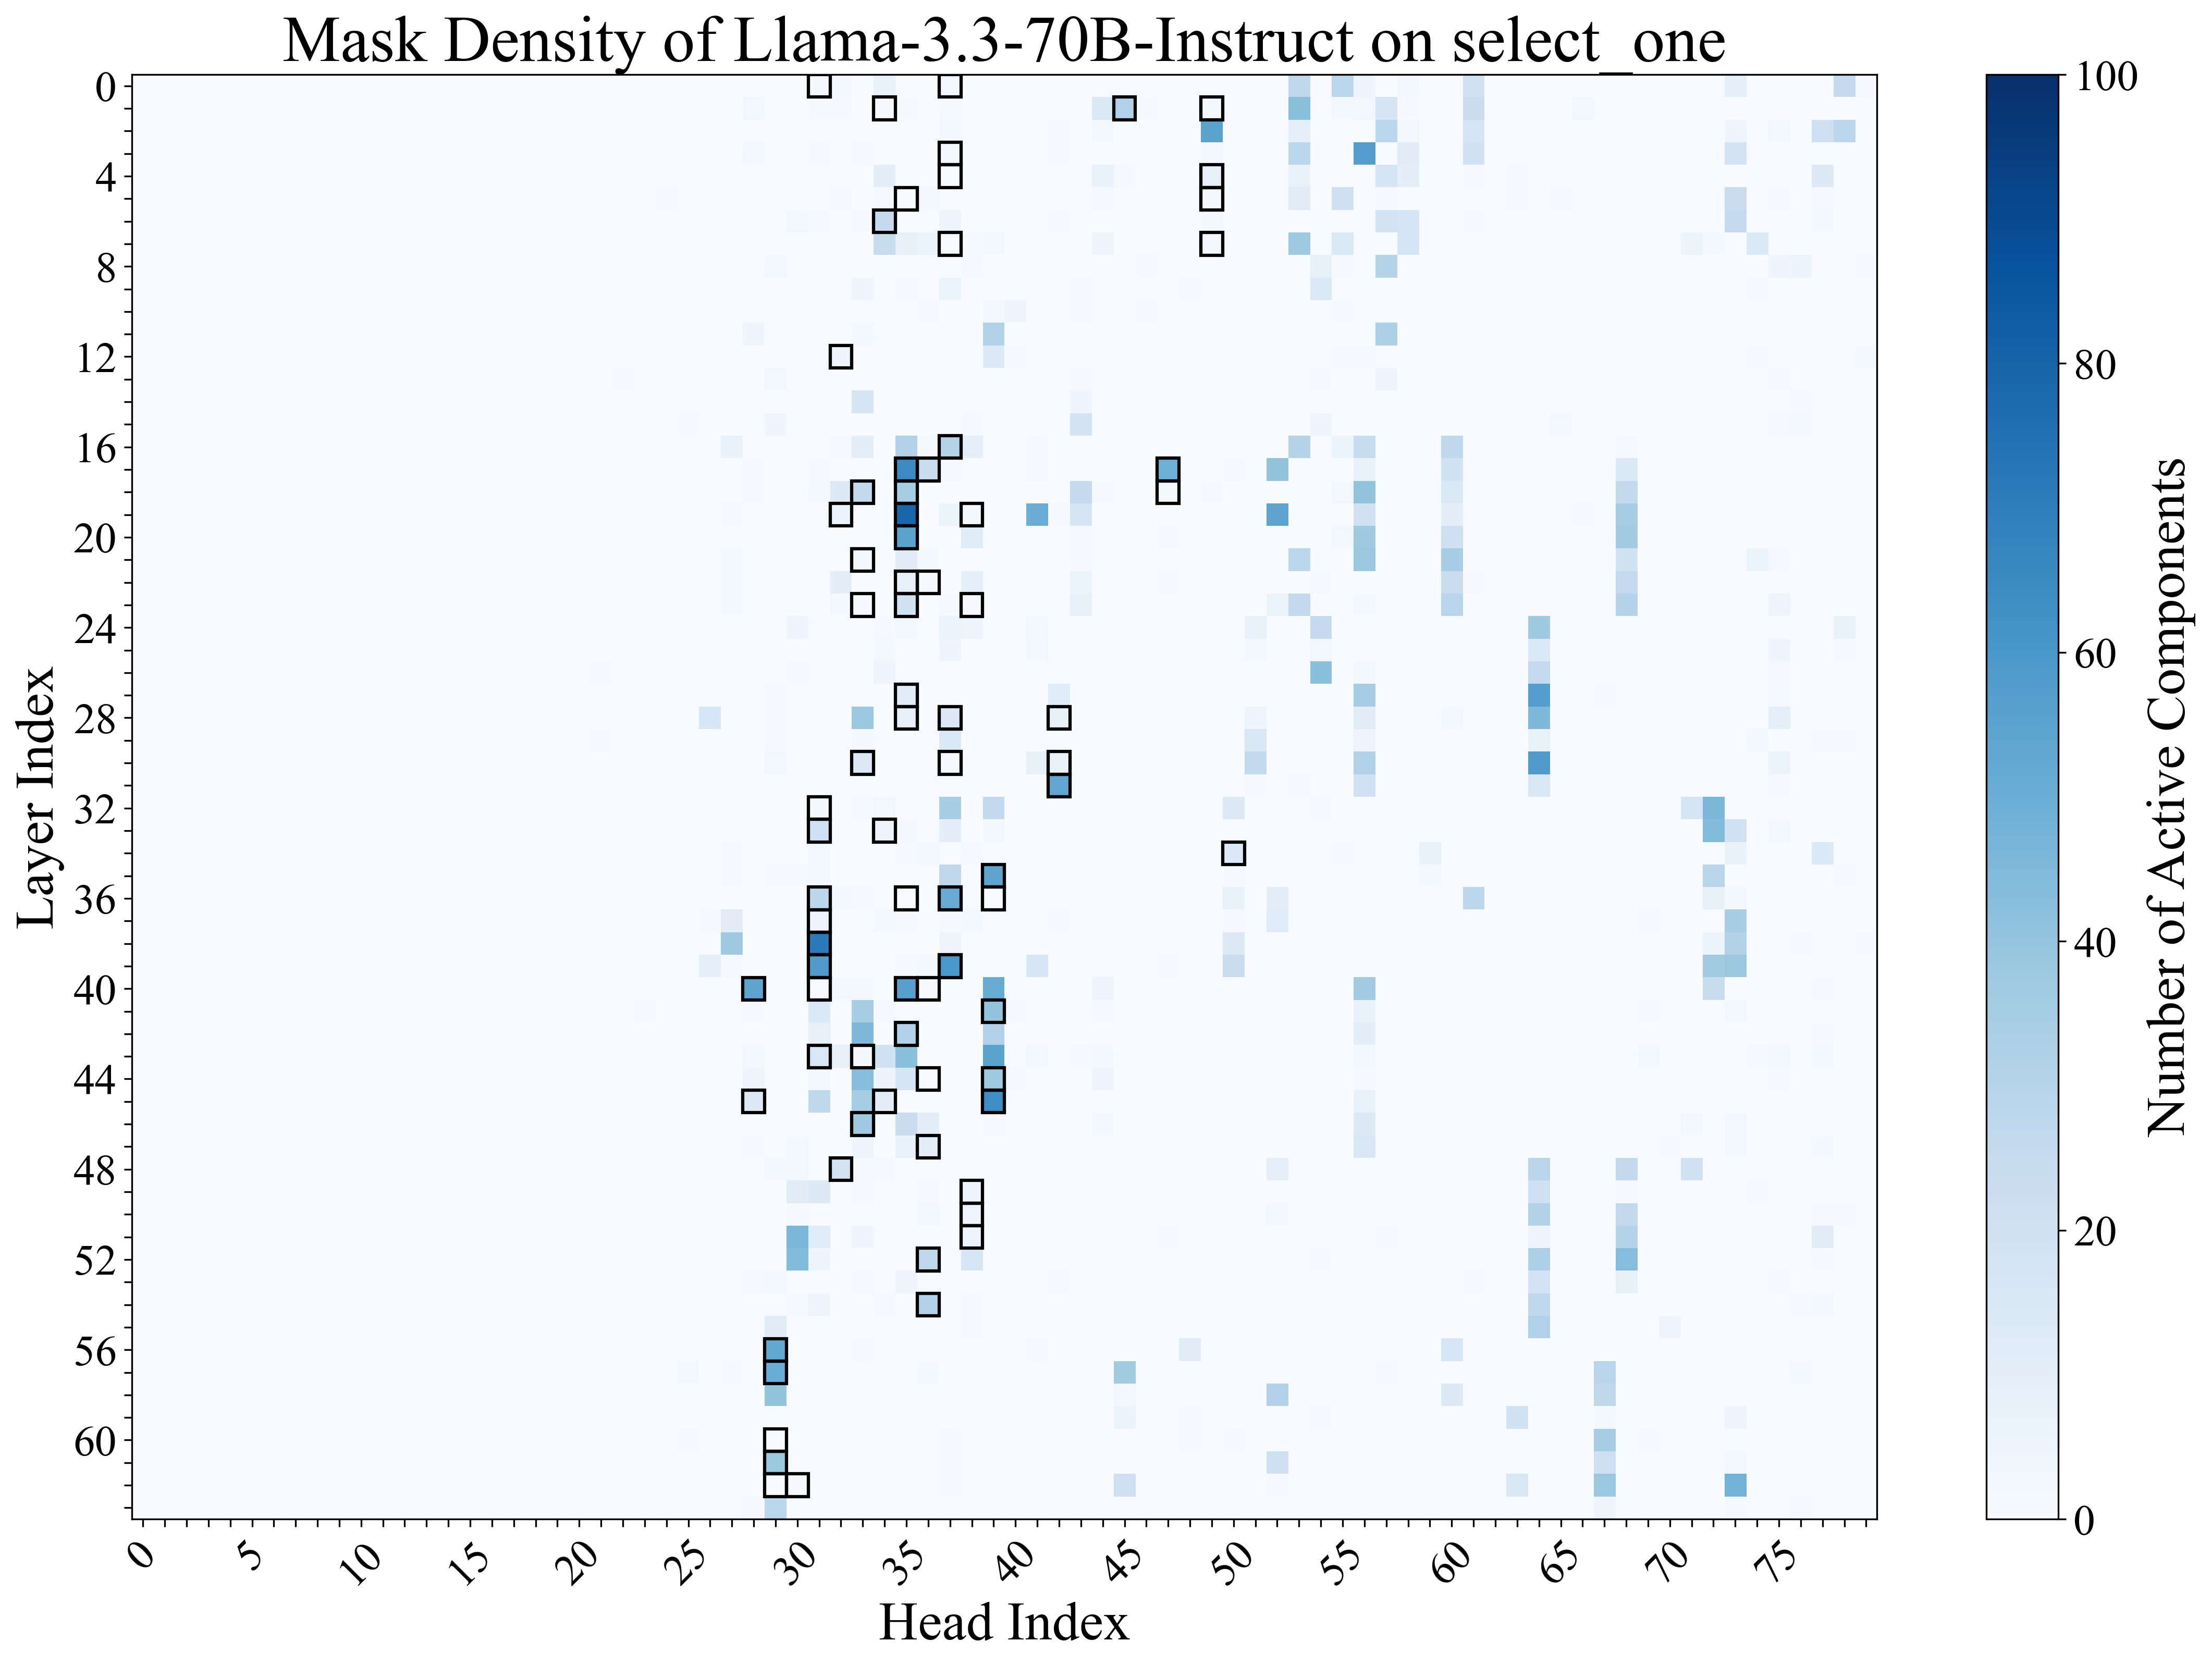

In [33]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches


plt.rcParams["figure.dpi"] = 300
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30

plt.figure(figsize=(18, 12))
plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

n_heads = mt.config.num_attention_heads
n_layer = mt.n_layer
mask_density = torch.zeros((n_heads, n_layer), dtype=torch.float32)

for (layer_idx, head_idx), mask in loaded_opt_results["masks"].items():
    mask_density[head_idx, layer_idx] = mask.sum().item()


def get_ticks(ticks, skip=5):
    ret = []
    for i in ticks:
        if i % skip == 0:
            ret.append(str(i))
        else:
            ret.append("")
    return ret


# plt.figure(figsize=(12, 6))
plt.imshow(mask_density.cpu(), cmap="Blues", aspect="auto", vmin=0, vmax=100)
plt.colorbar(label="Number of Active Components")
plt.xlabel("Head Index")
plt.ylabel("Layer Index")
plt.title(f"Mask Density of {mt.name.split('/')[-1]} on {select_task.task_name}")
plt.xticks(
    ticks=range(n_layer),
    labels=get_ticks(range(n_layer)),
    rotation=45,
)
plt.yticks(
    ticks=range(n_heads),
    labels=get_ticks(range(n_heads), skip=4),
)

ax = plt.gca()
# Draw borders around marked cells
for x, y in optimized_heads:
    print(x, y)
    # Create a Rectangle patch
    # Note: (x-0.5, y-0.5) positions the rectangle correctly around the cell
    # Width and height of 1 covers exactly one cell
    rect = patches.Rectangle(
        (x - 0.5, y - 0.5),  # bottom-left corner
        1,  # width
        1,  # height
        linewidth=1.5,  # border thickness
        edgecolor="black",  # border color (you can change this)
        facecolor="none",  # no fill, just border
    )
    ax.add_patch(rect)  # FIXED: This should be inside the loop!

plt.show()

## Validation

In [96]:
masks = loaded_opt_results["masks"]
zero_proj_heads = []
for (layer_idx, head_idx), mask in masks.items():
    # if (
    #     mask.sum().item()
    #     == 0
    #     or layer_idx >= 52
    # ):
    if (layer_idx, head_idx) not in optimized_heads:
        zero_proj_heads.append((layer_idx, head_idx))

len(zero_proj_heads)

5041

In [97]:
selected_heads = [
    (layer_idx, head_idx, mask.sum().item())
    for (layer_idx, head_idx), mask in masks.items()
    if (layer_idx, head_idx) not in zero_proj_heads
]

selected_heads.sort(key=lambda x: (x[2], x[0], x[1]), reverse=True)
selected_heads[:10]

[(35, 19, 79.0),
 (31, 38, 71.0),
 (35, 17, 65.0),
 (39, 45, 64.0),
 (37, 39, 60.0),
 (31, 39, 58.0),
 (35, 40, 56.0),
 (35, 20, 55.0),
 (39, 35, 54.0),
 (28, 40, 54.0)]

In [101]:
len(selected_heads)

79

In [102]:
validate_with_svds = {
    (layer_idx, head_idx): svd_per_head[(layer_idx, head_idx)]
    for layer_idx, head_idx, _ in selected_heads
}

len(validate_with_svds)

79

In [103]:
from src.functional import interpret_logits
from src.selection.data import get_first_token_id, get_options_for_answer

destination_sample, source_sample = validation_set[20]
print("Source:", source_sample.prompt(), ">>", source_sample.obj)
print("Destination:", destination_sample.prompt(), ">>", destination_sample.obj)
print(
    f"target: {destination_sample.metadata['track_type_obj']} | \"{mt.tokenizer.decode(destination_sample.metadata['track_type_obj_token_id'])}\""
)

ret_dict = validate_low_rank_qk_svd_bases_on_sample_pair(
    mt=mt,
    source_sample=source_sample,
    destination_sample=destination_sample,
    svd_per_head=validate_with_svds,
    masks={
        key: masks[key] for key in validate_with_svds.keys()
    },
    token_mapping={-1: -1},
    must_track_tokens=[],
    return_clean_predictions=True,
    debug=True,
)

Source: Options: Adam Sandler, Ons Jabeur, Larry Page.
Who among these people mentioned above is a entrepreneur by profession?
Answer: >> Larry Page
Destination: Options: Jim Carrey, Tim Cook, Oleksandr Usyk.
Who among these people mentioned above is a comedian by profession?
Answer: >> Jim Carrey
target: Tim Cook | " Tim"
Destination: Options: Stella McCartney, Amy Schumer, Kylian Mbappé, Bari Weiss, Brad Pitt, Gary Vaynerchuk.
Who among these people mentioned above is a soccer player by profession?
Answer: >> Ans:  Jim
2025-10-28 19:44:38 src.selection.functional DEBUG    Predictions: ['" Jim"[11641] (p=0.816, logit=22.125)', '" The"[578] (p=0.098, logit=20.000)', '" Among"[22395] (p=0.036, logit=19.000)', '" ("[320] (p=0.019, logit=18.375)', '" It"[1102] (p=0.003, logit=16.500)']
2025-10-28 19:44:38 src.selection.functional INFO     Combined attention matrix for all heads


Source: Options: Emma Stone, Pete Davidson, Caleb Plant, Tiger Woods, Bruno Mars, Cristiano Ronaldo.
Who among these people mentioned above is a actor by profession?
Answer: >> Ans:  Larry
2025-10-28 19:44:38 src.selection.functional DEBUG    Predictions: ['" Larry"[30390] (p=0.820, logit=20.875)', '" The"[578] (p=0.052, logit=18.125)', '" Among"[22395] (p=0.036, logit=17.750)', '" ("[320] (p=0.032, logit=17.625)', '" Adam"[15387] (p=0.017, logit=17.000)']
2025-10-28 19:44:38 src.selection.functional INFO     Combined attention matrix for all heads


attentions.shape=torch.Size([80, 1, 64, 30, 30])


2025-10-28 19:44:39 __main__ DEBUG    ----------------------------------------------------------------------------------------------------
2025-10-28 19:44:39 __main__ DEBUG    target: Tim Cook | " Tim"
2025-10-28 19:44:39 __main__ DEBUG    Patched pred : ['" Tim"[9538] (p=0.848, logit=22.625)', '" The"[578] (p=0.061, logit=20.000)', '" Among"[22395] (p=0.054, logit=19.875)', '" ("[320] (p=0.011, logit=18.250)', '" Ole"[33797] (p=0.006, logit=17.750)']
2025-10-28 19:44:39 __main__ DEBUG    Patched track: ['" Tim"[9538] (p=0.848, logit=22.625)', '" Ole"[33797] (p=0.006, logit=17.750)', '" Jim"[11641] (p=0.001, logit=16.250)', '" Larry"[30390] (p=0.000, logit=8.562)']
2025-10-28 19:44:39 __main__ DEBUG    ----------------------------------------------------------------------------------------------------


In [104]:
from tqdm.auto import tqdm

validation_results = []
for destination, source in tqdm(validation_set):
    # destination = copy.deepcopy(destination)
    # source = copy.deepcopy(source)
    # destination.default_option_style = "bulleted"
    # source.prompt_template = select_task.prompt_templates[2]
    # destination.prompt_template = select_task.prompt_templates[2]

    # source_tokenized = prepare_input(prompts=[source.prompt()], tokenizer=mt)
    # destination_tokenized = prepare_input(prompts=[destination.prompt()], tokenizer=mt)

    track_tokens = {
        "clean_obj": destination.ans_token_id,
        "corrupt_obj": source.ans_token_id,
        "target_obj": destination.metadata["track_type_obj_token_id"],
    }

    pair_result = validate_low_rank_qk_svd_bases_on_sample_pair(
        mt=mt,
        destination_sample=destination,
        source_sample=source,
        svd_per_head=validate_with_svds,
        masks={key: masks[key] for key in validate_with_svds.keys()},
        token_mapping={-1: -1},
        must_track_tokens=list(track_tokens.values()),
        return_clean_predictions=True,
        debug=False,
    )
    das_patched_pred = pair_result["patched_predictions"]
    das_patched_track = pair_result["patched_track"]
    destination_pred = pair_result["destination_predictions"]
    destination_track = pair_result["destination_track"]

    validation_results.append(
        {
            "destination": destination,
            "source": source,
            "patched_pred": das_patched_pred,
            "patched_track": das_patched_track,
            "destination_pred": destination_pred,
            "destination_track": destination_track,
            "track_tokens": track_tokens,
        }
    )

  0%|          | 0/512 [00:00<?, ?it/s]

In [105]:
import numpy as np

track_token_types = ["clean_obj", "target_obj"]

for token_type in track_token_types:
    print(f"{token_type}")
    ranks = {"clean": [], "patch": []}
    logits = {"clean": [], "patch": []}
    for result in validation_results:
        target_tok_id = result["track_tokens"][token_type]
        clean_rank, clean_pred = result["destination_track"][target_tok_id]
        patch_rank, patch_pred = result["patched_track"][target_tok_id]
        ranks["clean"].append(clean_rank)
        ranks["patch"].append(patch_rank)
        logits["clean"].append(clean_pred.logit)
        logits["patch"].append(patch_pred.logit)

    attr = {
        "rank": ranks,
        "logit": logits,
    }
    for key in attr:
        clean = np.array(attr[key]["clean"])
        patch = np.array(attr[key]["patch"])
        delta = patch - clean
        print(
            f"{key}: clean {clean.mean():.2f} ± {clean.std():.2f} -> patch {patch.mean():.2f} ± {patch.std():.2f} | delta {delta.mean():.2f} ± {delta.std():.2f}"
        )


top_1_accuracy = 0
failed_cases = []
for result in validation_results:
    target_tok_id = result["destination"].metadata["track_type_obj_token_id"]
    patched_track = result["patched_track"]
    if patched_track[list(patched_track.keys())[0]][1].token_id == target_tok_id:
        top_1_accuracy += 1

    else:
        failed_cases.append(result)

causality = top_1_accuracy / len(validation_results)
print(f"causality: {causality: .4f} ({top_1_accuracy}/{len(validation_results)})")

clean_obj
rank: clean 1.00 ± 0.04 -> patch 98.37 ± 197.32 | delta 97.37 ± 197.32
logit: clean 22.25 ± 0.72 -> patch 13.35 ± 3.29 | delta -8.90 ± 3.39
target_obj
rank: clean 64.75 ± 174.35 -> patch 3.71 ± 15.90 | delta -61.04 ± 175.37
logit: clean 13.81 ± 2.41 -> patch 19.77 ± 2.13 | delta 5.96 ± 3.23
causality:  0.7227 (370/512)


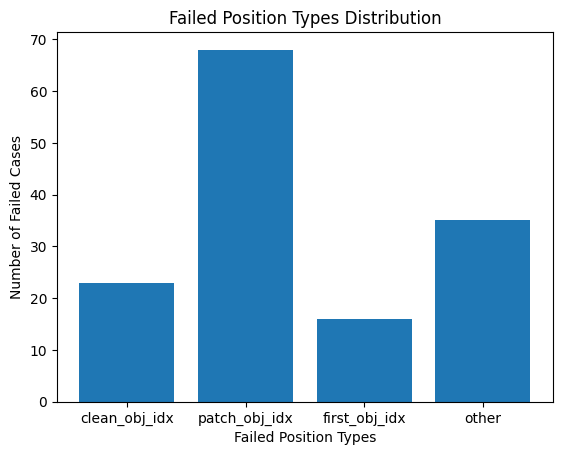

: 

In [ ]:
#! find the positions after the patched intervention.
# Is it looking at the first one, or the position of the
# previous answer?

from src.functional import is_nontrivial_prefix

failed_pos_track = {
    "clean_obj_idx": [],
    "patch_obj_idx": [],
    "first_obj_idx": [],
    "other": [],
}

for failed_case in failed_cases:
    destination = failed_case["destination"]
    source = failed_case["source"]
    int_track = failed_case["patched_track"]
    clean_track = failed_case["destination_track"]
    clean_obj_idx = destination.obj_idx
    patch_obj_idx = source.obj_idx

    int_top_tok = list(int_track.keys())[0]
    int_top_tok = int_track[int_top_tok][1].token.strip()
    int_top_obj = None
    for opt in destination.options:
        if is_nontrivial_prefix(int_top_tok, opt):
            int_top_obj = opt
            break
    int_top_idx = destination.options.index(int_top_obj)

    if int_top_idx == clean_obj_idx:
        failed_pos_track["clean_obj_idx"].append(failed_case)
    elif int_top_idx == patch_obj_idx:
        failed_pos_track["patch_obj_idx"].append(failed_case)
    elif int_top_idx == 0:
        failed_pos_track["first_obj_idx"].append(failed_case)
    else:
        failed_pos_track["other"].append(failed_case)


from matplotlib import pyplot as plt

plt.rcdefaults()
x_vals = failed_pos_track.keys()
y_vals = [len(failed_pos_track[key]) for key in x_vals]
plt.bar(x_vals, y_vals)
plt.xlabel("Failed Position Types")
plt.ylabel("Number of Failed Cases")
plt.title("Failed Position Types Distribution")
plt.show()